## SNR - fig1_convergence test

In [3]:
import time, datetime
import numpy as np
from numpy import zeros, sqrt, pi, vectorize
from numpy.linalg import pinv, inv
from multiprocessing import Process, Queue
#import matplotlib
#matplotlib.use('Qt4Agg')
import matplotlib.pyplot as plt
%matplotlib inline
from error_analysis_class import *
from noshellavg import *
from matplotlib.backends.backend_pdf import PdfPages

%load_ext autoreload
%autoreload 2

## Initial settings 

In [4]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [5]:
def SNR_convergence_test(RSDPower, kmin = 0.001, kmax = 2, reverse = None, re = None):

    rcut_max = get_closest_index_in_data( RMAX, RSDPower.rmax )
    rcut_min = get_closest_index_in_data( RMIN, RSDPower.rmin )
    kcut_min = get_closest_index_in_data( kmin, RSDPower.kmin_y )
    kcut_max = get_closest_index_in_data( kmax, RSDPower.kmax_y )
    
    
    
    file = 'matterpower_z_0.55.dat'  # from camb (z=0.55)
    RSDPower.MatterPower(file = file)
    # power spectrum multipoles l = 0,2,4
    RSDPower.multipole_P_band_all()

    # derivative dXi/dp
    RSDPower.derivative_Xi_band_all()

    # P covariance matrix ( nine submatrices C_ll' )
    RSDPower.RSDband_covariance_PP_all()

    # Xi covariance matrix ( nine submatrices C_ll' )
    RSDPower.covariance_Xi_all()
    RSDPower.covariance_PXi_All()


    matricesXi = [RSDPower.covariance00[rcut_max:rcut_min+1,rcut_max:rcut_min+1],\
                  RSDPower.covariance02[rcut_max:rcut_min+1,rcut_max:rcut_min+1],\
                  RSDPower.covariance04[rcut_max:rcut_min+1,rcut_max:rcut_min+1],\
                  np.transpose(RSDPower.covariance02[rcut_max:rcut_min+1,rcut_max:rcut_min+1]),\
                  RSDPower.covariance22[rcut_max:rcut_min+1,rcut_max:rcut_min+1],\
                  RSDPower.covariance24[rcut_max:rcut_min+1,rcut_max:rcut_min+1],\
                  np.transpose(RSDPower.covariance04[rcut_max:rcut_min+1,rcut_max:rcut_min+1]),\
                  np.transpose(RSDPower.covariance24[rcut_max:rcut_min+1,rcut_max:rcut_min+1]),\
                  RSDPower.covariance44[rcut_max:rcut_min+1,rcut_max:rcut_min+1]]

    matricesPP_all = [RSDPower.covariance_PP00,RSDPower.covariance_PP02,\
                    RSDPower.covariance_PP04,RSDPower.covariance_PP02,\
                    RSDPower.covariance_PP22,RSDPower.covariance_PP24,\
                    RSDPower.covariance_PP04,RSDPower.covariance_PP24,\
                    RSDPower.covariance_PP44]

    matricesPP = [RSDPower.covariance_PP00[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP02[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP04[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP02[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP22[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP24[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP04[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP24[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP44[kcut_min:kcut_max+1,kcut_min:kcut_max+1]]

    matricesPXi = [RSDPower.covariance_PXi00[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
                 RSDPower.covariance_PXi02[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
                 RSDPower.covariance_PXi04[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
                 RSDPower.covariance_PXi20[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
                 RSDPower.covariance_PXi22[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
                 RSDPower.covariance_PXi24[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
                 RSDPower.covariance_PXi40[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
                 RSDPower.covariance_PXi42[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
                 RSDPower.covariance_PXi44[kcut_min:kcut_max+1,rcut_max:rcut_min+1]]


    l1 = RSDPower.kcenter_y.size
    l2 = rcut_min+1 - rcut_max
    l3 = kcut_max+1 - kcut_min

    # combining covariances
    C_matrix3PP_all = CombineCovariance3(l1, matricesPP_all)
    C_matrix3PP = CombineCovariance3(l3, matricesPP)
    C_matrix3Xi = CombineCovariance3(l2, matricesXi)

    #C_matrix3PXi = np.zeros((C_matrix3PXi.shape))
    C_matrix3PXi, C_matrix3XiP = CombineCrossCovariance3(l3, l2, matricesPXi, transpose = True)
    C_matrix3_tot = np.concatenate((np.concatenate((C_matrix3PP, C_matrix3PXi), axis=1),\
                                    np.concatenate((C_matrix3PXi.T, C_matrix3Xi), axis=1)), axis = 0)



    # inverting matrices
    from test_SNR import blockwiseInversion
    FisherP_all = inv(C_matrix3PP_all)
    FisherP = inv(C_matrix3PP)
    FisherXi = inv(C_matrix3Xi)
    print '/nFisherXi', np.sum(FisherXi.diagonal() <= 0.0)
    
    Fisher3_tot = pinv(C_matrix3_tot, rcond = 1e-30)
    
    """
    rcondnum = np.arange(20, 13, -1)
    for rc in rcondnum:
        Fisher3_tot = pinv(C_matrix3_tot, rcond = 10**(-1*rc))
        neg = np.sum(Fisher3_tot.diagonal() <=0.0)
        print rc, neg
        if neg == 0 : break
    if rc == 14 : raise ValueError("Inversion failed : rcond exceeds 1e-15")   
    """
       
    #FisherXi = blockwiseInversion( C_matrix3Xi, rcut_min+1-rcut_max )
    #Fisher3_tot = blockwiseInversion( C_matrix3_tot, 3 * (kcut_max+1-kcut_min) )

    # derivatives
    derivative_P0 = np.identity(RSDPower.kcenter_y.size)[:,kcut_min:kcut_max+1]
    Pzeros = np.zeros((derivative_P0.shape))

    derivative_P = np.concatenate((np.concatenate((derivative_P0, Pzeros, Pzeros),axis=1 ),\
                                   np.concatenate((Pzeros, derivative_P0, Pzeros),axis=1 ),\
                                   np.concatenate((Pzeros, Pzeros, derivative_P0),axis=1 )), axis=0)
    Xizeros = np.zeros((RSDPower.dxip0[:,rcut_max:rcut_min+1].shape))
    derivative_correl_avg = np.concatenate(( np.concatenate((RSDPower.dxip0[:,rcut_max:rcut_min+1],Xizeros,Xizeros), axis=1),\
                                            np.concatenate((Xizeros,RSDPower.dxip2[:,rcut_max:rcut_min+1],Xizeros), axis=1),\
                                            np.concatenate((Xizeros,Xizeros,RSDPower.dxip4[:,rcut_max:rcut_min+1]), axis=1)),axis=0 )
    Derivatives = np.concatenate((derivative_P,derivative_correl_avg), axis=1)

    
    
    # Bandpower Fisher matrices from different estimators
    FisherBand_P = FisherP.copy()
    FisherBand_P_all = FisherP_all.copy()
    FisherBand_Xi = FisherProjection_Fishergiven(derivative_correl_avg, FisherXi)
    FisherBand_tot = FisherProjection_Fishergiven(Derivatives, Fisher3_tot)
    
    
    from test_SNR import reorderingVector, reordering

    m_P0 = RSDPower.multipole_bandpower0[kcut_min:kcut_max+1]
    m_P2 = RSDPower.multipole_bandpower2[kcut_min:kcut_max+1]
    m_P4 = RSDPower.multipole_bandpower4[kcut_min:kcut_max+1]
    m_P = reorderingVector( [m_P0, m_P2, m_P4] )

    re_FisherBand_P_all, _ = reordering( RSDPower, FisherBand_P_all)
    re_FisherBand_P, _ = reordering( RSDPower, FisherBand_P)
    re_FisherBand_Xi, m_P_all = reordering( RSDPower, FisherBand_Xi)
    re_FisherBand_tot, _ = reordering( RSDPower, FisherBand_tot)

    
    if reverse == True:
        re_FisherBand_P = np.fliplr(np.rot90(re_FisherBand_P))
        re_FisherBand_P_all = np.fliplr(np.rot90(re_FisherBand_P_all))
        re_FisherBand_Xi = np.fliplr(np.rot90(re_FisherBand_Xi))
        re_FisherBand_tot = np.fliplr(np.rot90(re_FisherBand_tot))
        m_P = m_P[::-1]
        m_P_all = m_P_all[::-1]
    
    
    #P
    from test_SNR import blockwise
    
    FP = re_FisherBand_P_all.copy()
    PP = m_P_all.copy()

    SNRlist_P = []
    SNRP = np.dot( np.dot(PP, FP), PP.T )
    SNRlist_P.append(SNRP)
    for j in range(1, PP.size/3):
        PP = PP[:-3]
        for i in range(0,3):
            FP = blockwise( FP )
        SNRP = np.dot( np.dot(PP, FP), PP.T )
        SNRlist_P.append(SNRP)

    SNRlist_P = np.array(SNRlist_P[::-1]).ravel()
    kklist = RSDPower.kcenter_y#[kcut_min:kcut_max+1]

    # Xi

    F = re_FisherBand_Xi.copy()
    P = m_P_all.copy()

    SNRlist = []
    SNR = np.dot( np.dot(P, F), P.T )
    SNRlist.append(SNR)
    for j in range(1, P.size/3):
        P = P[:-3]
        for i in range(0,3):
            F = blockwise( F )
        SNR = np.dot( np.dot(P, F), P.T )
        SNRlist.append(SNR)

    SNRlist = np.array(SNRlist[::-1]).ravel()
    kklist2 = RSDPower.kcenter_y

    # tot

    Ft = re_FisherBand_tot.copy()
    Pt = m_P_all.copy()

    SNRlist_t = []
    SNRt = np.dot( np.dot(Pt, Ft), Pt.T )
    SNRlist_t.append(SNRt)
    for j in range(1, Pt.size/3):
        Pt = Pt[:-3]
        for i in range(0,3):
            Ft = blockwise( Ft )
        SNRt = np.dot( np.dot(Pt, Ft), Pt.T )
        SNRlist_t.append(SNRt)

    SNRlist_t = np.array(SNRlist_t[::-1]).ravel()
    #kklist2 = RSDPower.kcenter_y
    
    if reverse == True:
        kklist = kklist[::-1]
        kklist2 = kklist2[::-1]
        
    return RSDPower, kklist, SNRlist_P, kklist2, SNRlist, kklist2, SNRlist_t 

In [6]:
def SNR_P_Xi(RSDPower, kmin = 0.001, kmax = 2, reverse = None, re = None):

    rcut_max = get_closest_index_in_data( RMAX, RSDPower.rmax )
    rcut_min = get_closest_index_in_data( RMIN, RSDPower.rmin )
    kcut_min = get_closest_index_in_data( kmin, RSDPower.kmin_y )
    kcut_max = get_closest_index_in_data( kmax, RSDPower.kmax_y )
    
    file = 'matterpower_z_0.55.dat'  # from camb (z=0.55)
    RSDPower.MatterPower(file = file)
    # power spectrum multipoles l = 0,2,4
    RSDPower.multipole_P_band_all()

    # derivative dXi/dp
    RSDPower.derivative_Xi_band_all()

    # P covariance matrix ( nine submatrices C_ll' )
    RSDPower.RSDband_covariance_PP_all()

    # Xi covariance matrix ( nine submatrices C_ll' )
    RSDPower.covariance_Xi_all()


    matricesXi = [RSDPower.covariance00[rcut_max:rcut_min+1,rcut_max:rcut_min+1],\
                  RSDPower.covariance02[rcut_max:rcut_min+1,rcut_max:rcut_min+1],\
                  RSDPower.covariance04[rcut_max:rcut_min+1,rcut_max:rcut_min+1],\
                  np.transpose(RSDPower.covariance02[rcut_max:rcut_min+1,rcut_max:rcut_min+1]),\
                  RSDPower.covariance22[rcut_max:rcut_min+1,rcut_max:rcut_min+1],\
                  RSDPower.covariance24[rcut_max:rcut_min+1,rcut_max:rcut_min+1],\
                  np.transpose(RSDPower.covariance04[rcut_max:rcut_min+1,rcut_max:rcut_min+1]),\
                  np.transpose(RSDPower.covariance24[rcut_max:rcut_min+1,rcut_max:rcut_min+1]),\
                  RSDPower.covariance44[rcut_max:rcut_min+1,rcut_max:rcut_min+1]]

    matricesPP_all = [RSDPower.covariance_PP00,RSDPower.covariance_PP02,\
                    RSDPower.covariance_PP04,RSDPower.covariance_PP02,\
                    RSDPower.covariance_PP22,RSDPower.covariance_PP24,\
                    RSDPower.covariance_PP04,RSDPower.covariance_PP24,\
                    RSDPower.covariance_PP44]

    matricesPP = [RSDPower.covariance_PP00[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP02[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP04[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP02[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP22[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP24[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP04[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP24[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP44[kcut_min:kcut_max+1,kcut_min:kcut_max+1]]



    l1 = RSDPower.kcenter_y.size
    l2 = rcut_min+1 - rcut_max
    l3 = kcut_max+1 - kcut_min

    # combining covariances
    C_matrix3PP_all = CombineCovariance3(l1, matricesPP_all)
    C_matrix3PP = CombineCovariance3(l3, matricesPP)
    C_matrix3Xi = CombineCovariance3(l2, matricesXi)

    # inverting matrices
    from test_SNR import blockwiseInversion
    FisherP_all = inv(C_matrix3PP_all)
    FisherP = inv(C_matrix3PP)
    FisherXi = inv(C_matrix3Xi)
    print '/nFisherXi', np.sum(FisherXi.diagonal() <= 0.0)
    
    # derivatives
    derivative_P0 = np.identity(RSDPower.kcenter_y.size)[:,kcut_min:kcut_max+1]
    Pzeros = np.zeros((derivative_P0.shape))

    derivative_P = np.concatenate((np.concatenate((derivative_P0, Pzeros, Pzeros),axis=1 ),\
                                   np.concatenate((Pzeros, derivative_P0, Pzeros),axis=1 ),\
                                   np.concatenate((Pzeros, Pzeros, derivative_P0),axis=1 )), axis=0)
    Xizeros = np.zeros((RSDPower.dxip0[:,rcut_max:rcut_min+1].shape))
    derivative_correl_avg = np.concatenate(( np.concatenate((RSDPower.dxip0[:,rcut_max:rcut_min+1],Xizeros,Xizeros), axis=1),\
                                            np.concatenate((Xizeros,RSDPower.dxip2[:,rcut_max:rcut_min+1],Xizeros), axis=1),\
                                            np.concatenate((Xizeros,Xizeros,RSDPower.dxip4[:,rcut_max:rcut_min+1]), axis=1)),axis=0 )


    
    
    # Bandpower Fisher matrices from different estimators
    FisherBand_P = FisherP.copy()
    FisherBand_P_all = FisherP_all.copy()
    FisherBand_Xi = FisherProjection_Fishergiven(derivative_correl_avg, FisherXi)
    #FisherBand_tot = FisherProjection_Fishergiven(Derivatives, Fisher3_tot)
    
    
    from test_SNR import reorderingVector, reordering

    m_P0 = RSDPower.multipole_bandpower0[kcut_min:kcut_max+1]
    m_P2 = RSDPower.multipole_bandpower2[kcut_min:kcut_max+1]
    m_P4 = RSDPower.multipole_bandpower4[kcut_min:kcut_max+1]
    m_P = reorderingVector( [m_P0, m_P2, m_P4] )

    re_FisherBand_P_all, _ = reordering( RSDPower, FisherBand_P_all)
    re_FisherBand_P, _ = reordering( RSDPower, FisherBand_P)
    re_FisherBand_Xi, m_P_all = reordering( RSDPower, FisherBand_Xi)
    #re_FisherBand_tot, _ = reordering( RSDPower, FisherBand_tot)

    
    if reverse == True:
        re_FisherBand_P = np.fliplr(np.rot90(re_FisherBand_P))
        re_FisherBand_P_all = np.fliplr(np.rot90(re_FisherBand_P_all))
        re_FisherBand_Xi = np.fliplr(np.rot90(re_FisherBand_Xi))
        #re_FisherBand_tot = np.fliplr(np.rot90(re_FisherBand_tot))
        m_P = m_P[::-1]
        m_P_all = m_P_all[::-1]
    
    
    #P
    from test_SNR import blockwise

    FP = re_FisherBand_P_all.copy()
    PP = m_P_all.copy()

    SNRlist_P = []
    SNRP = np.dot( np.dot(PP, FP), PP.T )
    SNRlist_P.append(SNRP)
    for j in range(1, PP.size/3):
        PP = PP[:-3]
        for i in range(0,3):
            FP = blockwise( FP )
        SNRP = np.dot( np.dot(PP, FP), PP.T )
        SNRlist_P.append(SNRP)

    SNRlist_P = np.array(SNRlist_P[::-1]).ravel()
    kklist = RSDPower.kcenter_y#[kcut_min:kcut_max+1]

    # Xi

    F = re_FisherBand_Xi.copy()
    P = m_P_all.copy()

    SNRlist = []
    SNR = np.dot( np.dot(P, F), P.T )
    SNRlist.append(SNR)
    for j in range(1, P.size/3):
        P = P[:-3]
        for i in range(0,3):
            F = blockwise( F )
        SNR = np.dot( np.dot(P, F), P.T )
        SNRlist.append(SNR)

    SNRlist = np.array(SNRlist[::-1]).ravel()
    kklist2 = RSDPower.kcenter_y
        
    return RSDPower, kklist, SNRlist_P, kklist2, SNRlist

In [7]:
def BandPowerFisher(RSDPower, RMIN = 0.1, RMAX = 180, kmin = 0.001, kmax = 2, reorder=False):

    #RMAX = RSDPower.RMAX
    #RMIN = RSDPower.RMIN
    
    rcut_max = get_closest_index_in_data( RMAX, RSDPower.rmax )
    rcut_min = get_closest_index_in_data( RMIN, RSDPower.rmin )
    kcut_min = get_closest_index_in_data( kmin, RSDPower.kmin_y )   
    kcut_max = get_closest_index_in_data( kmax, RSDPower.kmax_y )
    
    print 'rcut_max, rcut_min ', RSDPower.rmax[rcut_max], RSDPower.rmin[rcut_min]
    
    file = 'matterpower_z_0.55.dat'  # from camb (z=0.55)
    RSDPower.MatterPower(file = file)
    # power spectrum multipoles l = 0,2,4
    RSDPower.multipole_P_band_all()

    # derivative dXi/dp
    RSDPower.derivative_Xi_band_all()

    # P covariance matrix ( nine submatrices C_ll' )
    RSDPower.RSDband_covariance_PP_all()

    # Xi covariance matrix ( nine submatrices C_ll' )
    RSDPower.covariance_Xi_all()
    RSDPower.covariance_PXi_All()

    
    matricesXi = [RSDPower.covariance00[rcut_max:rcut_min+1,rcut_max:rcut_min+1],\
              RSDPower.covariance02[rcut_max:rcut_min+1,rcut_max:rcut_min+1],\
              RSDPower.covariance04[rcut_max:rcut_min+1,rcut_max:rcut_min+1],\
              np.transpose(RSDPower.covariance02[rcut_max:rcut_min+1,rcut_max:rcut_min+1]),\
              RSDPower.covariance22[rcut_max:rcut_min+1,rcut_max:rcut_min+1],\
              RSDPower.covariance24[rcut_max:rcut_min+1,rcut_max:rcut_min+1],\
              np.transpose(RSDPower.covariance04[rcut_max:rcut_min+1,rcut_max:rcut_min+1]),\
              np.transpose(RSDPower.covariance24[rcut_max:rcut_min+1,rcut_max:rcut_min+1]),\
              RSDPower.covariance44[rcut_max:rcut_min+1,rcut_max:rcut_min+1]]

    matricesPP_all = [RSDPower.covariance_PP00,RSDPower.covariance_PP02,\
                    RSDPower.covariance_PP04,RSDPower.covariance_PP02,\
                    RSDPower.covariance_PP22,RSDPower.covariance_PP24,\
                    RSDPower.covariance_PP04,RSDPower.covariance_PP24,\
                    RSDPower.covariance_PP44]

    matricesPP = [RSDPower.covariance_PP00[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP02[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP04[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP02[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP22[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP24[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP04[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP24[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP44[kcut_min:kcut_max+1,kcut_min:kcut_max+1]]

    matricesPXi = [RSDPower.covariance_PXi00[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
                 RSDPower.covariance_PXi02[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
                 RSDPower.covariance_PXi04[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
                 RSDPower.covariance_PXi20[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
                 RSDPower.covariance_PXi22[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
                 RSDPower.covariance_PXi24[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
                 RSDPower.covariance_PXi40[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
                 RSDPower.covariance_PXi42[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
                 RSDPower.covariance_PXi44[kcut_min:kcut_max+1,rcut_max:rcut_min+1]]


    l1 = RSDPower.kcenter_y.size
    l2 = rcut_min+1 - rcut_max
    l3 = kcut_max+1 - kcut_min
    
    
    # combining covariances
    C_matrix3PP_all = CombineCovariance3(l1, matricesPP_all)
    C_matrix3PP = CombineCovariance3(l3, matricesPP)
    C_matrix3Xi = CombineCovariance3(l2, matricesXi)

    #C_matrix3PXi = np.zeros((C_matrix3PXi.shape))
    C_matrix3PXi, C_matrix3XiP = CombineCrossCovariance3(l3, l2, matricesPXi, transpose = True)
    C_matrix3_tot = np.concatenate((np.concatenate((C_matrix3PP, C_matrix3PXi), axis=1),\
                                    np.concatenate((C_matrix3PXi.T, C_matrix3Xi), axis=1)), axis = 0)


    
    # inverting matrices
    from test_SNR import blockwiseInversion
    FisherP_all = inv(C_matrix3PP_all)
    FisherP = inv(C_matrix3PP)    
    FisherXi = inv(C_matrix3Xi)
    print '\nFisherXi', np.sum(FisherXi.diagonal() <= 0.0)

    Fisher3_tot = pinv(C_matrix3_tot, rcond = 1e-30)
                       
    """
    rcondnum = np.arange(30, 10, -1)
    for rc in rcondnum:
        Fisher3_tot = pinv(C_matrix3_tot, rcond = 10**(-1*rc))
        neg = np.sum(Fisher3_tot.diagonal() <=0.0)
        print rc, neg
        if neg == 0 : break
    #if rc == 14 : raise ValueError("Inversion failed : rcond exceeds 1e-15")   
    #FisherXi = blockwiseInversion( C_matrix3Xi, rcut_min+1-rcut_max )
    #Fisher3_tot = blockwiseInversion( C_matrix3_tot, 3 * (kcut_max+1-kcut_min) )
    """
    
    
    # derivatives
    derivative_P0 = np.identity(RSDPower.kcenter_y.size)[:,kcut_min:kcut_max+1]
    Pzeros = np.zeros((derivative_P0.shape))

    derivative_P = np.concatenate((np.concatenate((derivative_P0, Pzeros, Pzeros),axis=1 ),\
                                   np.concatenate((Pzeros, derivative_P0, Pzeros),axis=1 ),\
                                   np.concatenate((Pzeros, Pzeros, derivative_P0),axis=1 )), axis=0)
    Xizeros = np.zeros((RSDPower.dxip0[:,rcut_max:rcut_min+1].shape))
    derivative_correl_avg = np.concatenate(( np.concatenate((RSDPower.dxip0[:,rcut_max:rcut_min+1],Xizeros,Xizeros), axis=1),\
                                            np.concatenate((Xizeros,RSDPower.dxip2[:,rcut_max:rcut_min+1],Xizeros), axis=1),\
                                            np.concatenate((Xizeros,Xizeros,RSDPower.dxip4[:,rcut_max:rcut_min+1]), axis=1)),axis=0 )
    Derivatives = np.concatenate((derivative_P,derivative_correl_avg), axis=1)

    
    # Fisher.....
    FisherBand_P = FisherP.copy()
    FisherBand_P_all = FisherP_all.copy()
    FisherBand_Xi = FisherProjection_Fishergiven(derivative_correl_avg, FisherXi)
    FisherBand_tot = FisherProjection_Fishergiven(Derivatives, Fisher3_tot)
    
    
    # vector and reorder
    from test_SNR import reorderingVector, reordering, blockwise
    m_P0 = RSDPower.multipole_bandpower0[kcut_min:kcut_max+1]
    m_P2 = RSDPower.multipole_bandpower2[kcut_min:kcut_max+1]
    m_P4 = RSDPower.multipole_bandpower4[kcut_min:kcut_max+1]
    m_P = reorderingVector( [m_P0, m_P2, m_P4] )
    # Fisher reorering
    re_FisherBand_P_all, _ = reordering( RSDPower, FisherBand_P_all)
    re_FisherBand_P, _ = reordering( RSDPower, FisherBand_P)
    re_FisherBand_Xi, m_P_all = reordering( RSDPower, FisherBand_Xi)
    re_FisherBand_tot, _ = reordering( RSDPower, FisherBand_tot)

    #if reorder is False : return [m_P0, m_P2, m_P4], [FisherBand_P, FisherBand_Xi]
    #elif reorder is True : return m_P, m_P_all, re_FisherBand_P_all,re_FisherBand_P, re_FisherBand_Xi, re_FisherBand_tot
    
    return [m_P0, m_P2, m_P4], [FisherBand_P, FisherBand_Xi], m_P, m_P_all, re_FisherBand_P_all,re_FisherBand_P, re_FisherBand_Xi, re_FisherBand_tot

In [364]:
def CumulativeSNR_diag( FisherBand_P, FisherBand_Xi, data_vec = None, kmin=0.01, kmax = 2 ):
    # diagonal SNR
    #m_P, m_P_all, re_FisherBand_P_all,re_FisherBand_P, re_FisherBand_Xi, re_FisherBand_tot 
    
    [m_P0, m_P2, m_P4] =  data_vec
    ind = m_P0.size
    FP00 = FisherBand_P[:ind, :ind]
    FP02 = FisherBand_P[:ind, ind: 2* ind]
    FP04 = FisherBand_P[:ind, 2*ind:3*ind]
    FP22 = FisherBand_P[ind:2 * ind, ind: 2* ind]
    FP24 = FisherBand_P[ind:2 * ind, 2*ind:3 * ind]
    FP44 = FisherBand_P[2*ind:3 * ind, 2*ind: 3* ind]

    DiagSNR_P_all = m_P0**2 * FP00.diagonal() + m_P2**2 * FP22.diagonal() + m_P4**2 * FP44.diagonal() +\
    2*(m_P0 * m_P2 * FP02.diagonal() + m_P0*m_P4 * FP04.diagonal() + m_P2*m_P4 * FP24.diagonal())

    FXi00 = FisherBand_Xi[:ind, :ind]]
    FXi02 = FisherBand_Xi[:ind, ind: 2* ind]
    FXi04 = FisherBand_Xi[:ind, 2*ind:3*ind]
    FXi22 = FisherBand_Xi[ind:2 * ind, ind: 2* ind]
    FXi24 = FisherBand_Xi[ind:2 * ind, 2*ind:3 * ind]
    FXi44 = FisherBand_Xi[2*ind:3 * ind, 2*ind: 3* ind]

    DiagSNR_Xi_all = m_P0**2 * FXi00.diagonal() + m_P2**2 * FXi22.diagonal() + m_P4**2 * FXi44.diagonal() +\
    2*(m_P0*m_P2 * FXi02.diagonal() + m_P0*m_P4 * FXi04.diagonal() + m_P2*m_P4 * FXi24.diagonal())

    DiagSNR_Xi0 = m_P0**2 * FXi00.diagonal() 

    DiagCSNR_P = []
    DiagCSNR_Xi = []
    DiagCSNR_Xi0 = []

    sumP = 0
    sumXi = 0
    sumXi0 = 0
    for i in range(m_P0.size):
        sumP = sumP + DiagSNR_P_all[i]
        sumXi = sumXi + DiagSNR_Xi_all[i]
        sumXi0 = sumXi0 + DiagSNR_Xi0[i]
        DiagCSNR_P.append(sumP)
        DiagCSNR_Xi.append(sumXi)
        DiagCSNR_Xi0.append(sumXi0)

        
    kcut_min = get_closest_index_in_data( kmin, RSDPower.kmin_y )
    kcut_max = get_closest_index_in_data( kmax, RSDPower.kmax_y )
    
    return RSDPower.kcenter_y, np.array(DiagCSNR_P), np.array(DiagCSNR_Xi)



In [8]:
def CumulativeSNR(RSDPower, re_FisherBand_P_all, m_P_all, kmin, kmax):
    
    from test_SNR import blockwise
    
    kcut_min = get_closest_index_in_data( kmin, RSDPower.kmin_y )
    kcut_max = get_closest_index_in_data( kmax, RSDPower.kmax_y )

    FP = re_FisherBand_P_all.copy()[3*kcut_min:3*kcut_max+3, 3*kcut_min:3*kcut_max+3]
    PP = m_P_all.copy()[3*kcut_min:3*kcut_max+3]
    
    SNRlist_P = []
    SNRP = np.dot( np.dot(PP, FP), PP.T )
    SNRlist_P.append(SNRP)
    for j in range(1, PP.size/3):
        PP = PP[:-3]
        for i in range(0,3):
            FP = blockwise( FP )
        SNRP = np.dot( np.dot(PP, FP), PP.T )
        SNRlist_P.append(SNRP)

    SNRlist_P = np.array(SNRlist_P[::-1]).ravel()
    kklist = RSDPower.kcenter_y[kcut_min:kcut_max+1]
    
    return kklist, SNRlist_P

#### Band-power Fisher matrixes from different estimators

In [15]:
#FisherBand_P = FisherP.copy()
#FisherBand_P_all = FisherP_all.copy()
#FisherBand_Xi = FisherProjection_Fishergiven(derivative_correl_avg, FisherXi)
#FisherBand_tot = FisherProjection_Fishergiven(Derivatives, Fisher3_tot)

----

Plotting

In [13]:
#  (parameter description in class code)
# Fourier K 0.001~10
KMIN = 1e-10
KMAX = 2 # 361.32 #502.32
RMIN = 18
RMAX = 180

kmin = 1e-10
kmax = 0.2

# the number of k sample point should be 2^n+1 (b/c romb integration)
rN = 163 # (RMAX-int(RMIN)) * 2
kN = 2**10 + 1
kN_x = 1.
kN_y = 500
#subN = 2**5 + 1
# RSD class

In [ ]:
RSDPower = NoShell_covariance(KMIN, KMAX, RMIN, RMAX, kN, rN, kN_x, kN_y, logscale = False)
#_, kbin, SNR_P, kbin2, SNR_Xi, kbin2, SNR_tot = SNR_convergence_test(RSDPower)
#m_P, m_P_all, re_FisherBand_P_all,re_FisherBand_P, re_FisherBand_Xi, re_FisherBand_tot = \
#BandPowerFisher(RSDPower, RMIN = RMIN, RMAX = RMAX, kmin = kmin, kmax = kmax, reorder = True)
#[m_P0, m_P2, m_P4], [FisherBand_P, FisherBand_Xi] = \
#BandPowerFisher(RSDPower, RMIN = RMIN, RMAX = RMAX, kmin = kmin, kmax = kmax)

[m_P0, m_P2, m_P4], [FisherBand_P, FisherBand_Xi], m_P, m_P_all, re_FisherBand_P_all,re_FisherBand_P, re_FisherBand_Xi, re_FisherBand_tot \
= BandPowerFisher(RSDPower, RMIN = RMIN, RMAX = RMAX, kmin = kmin, kmax = kmax)

kbin, SNR_P = CumulativeSNR(RSDPower, re_FisherBand_P_all, m_P_all, kmin, kmax)
kbin2, SNR_Xi = CumulativeSNR(RSDPower, re_FisherBand_Xi, m_P_all, KMIN, KMAX)
kbin_tot, SNR_tot = CumulativeSNR(RSDPower, re_FisherBand_tot, m_P_all, KMIN, KMAX)
kbin_d, DiagCSNR_P, DiagCSNR_Xi =  CumulativeSNR_diag( FisherBand_P, FisherBand_Xi, data_vec = [m_P0, m_P2, m_P4])

In [83]:
k_s, SNR_P_s = CumulativeSNR(RSDPower, re_FisherBand_P_all, m_P_all, kmin, kmax)
DAT = np.column_stack((k_s, SNR_P_s ))
#np.savetxt('data_txt/snr.txt', DAT)
np.savetxt('data_txt/snr_kmax'+str(kmax)+'_kmin'+str(kmin)+'.txt', DAT)

In [84]:
kcolumn = np.zeros(kbin2.size)
SNR_P_column = kcolumn.copy()
kcolumn[:kbin.size] = kbin
SNR_P_column[:kbin.size] = SNR_P
DAT = np.column_stack((kcolumn, SNR_P_column, kbin2, SNR_Xi ))
#np.savetxt('data_txt/snr.txt', DAT)
np.savetxt('data_txt/snr_rmax'+str(RMAX)+'_rmin'+str(RMIN)+'.txt', DAT)

# kbin_tot, SNR_tot
DAT = np.column_stack((kbin_tot, SNR_tot ))
#np.savetxt('data_txt/snr.txt', DAT)
np.savetxt('data_txt/snr_tot_rmax'+str(RMAX)+'_rmin'+str(RMIN)+'_kmax'+str(kmax)+'_kmin'+str(kmin)+'.txt', DAT)

#kbin_d, DiagCSNR_P, DiagCSNR_Xi =  CumulativeSNR_diag( FisherBand_P, FisherBand_Xi, data_vec = [m_P0, m_P2, m_P4])
# diagonal data
#DAT = np.column_stack((kbin_d, DiagCSNR_P, DiagCSNR_Xi ))
#np.savetxt('data_txt/snr_diag_rmax'+str(RMAX)+'_rmin'+str(RMIN)+'.txt', DAT)

### Convergence test (fig1) 

In [504]:
kN_y = [100, 200, 300, 400, 500]
#kN_y = [100, 200]


kklist = []
SNRlist_P = []
kklist2 = []
SNRlist_Xi = []
SNRlist_tot = []
dklist = []

for k in kN_y:
    RSDPower = NoShell_covariance(KMIN, KMAX, RMIN, RMAX, kN, rN, kN_x, k, logscale = False)
    _, kbin, SNR_P, kbin2, SNR_Xi, kbin2, SNR_tot = SNR_convergence_test(RSDPower)
    kklist.append(kbin)
    kklist2.append(kbin2)
    SNRlist_P.append(SNR_P)
    SNRlist_Xi.append(SNR_Xi)
    SNRlist_tot.append(SNR_tot)
    dklist.append(RSDPower.dk_y)
    
    DAT = np.column_stack(( kbin, SNR_P, kbin2, SNR_Xi, kbin2, SNR_tot ))
    np.savetxt('data_txt/snr_comparison_dk{:>0.5f}.txt'.format(RSDPower.dk_y), DAT,\
               header = ' kbin, SNR_P, kbin2, SNR_Xi, kbin2, SNR_tot ' )


-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 500, N_x = 8193
dr = 0.400801603206, dk=nan, dk_y=0.020202020201


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 200, rN = 500, N_x = 8193
dr = 0.400801603206, dk=nan, dk_y=0.0100502512558


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 300, rN = 500, N_x = 8193
dr = 0.400801603206, dk=nan, dk_y=0.00668896321037


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 400, rN = 500, N_x = 8193
dr = 0.400801603206, dk=nan, dk_y=0.00501253132807


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 500, rN = 500, N_x = 8193
dr = 0.400801603206, dk=nan, dk_y=0.00400801603186


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

199 199
299 299
399 399
499 499
fig save to figure/snr_convergence.pdf


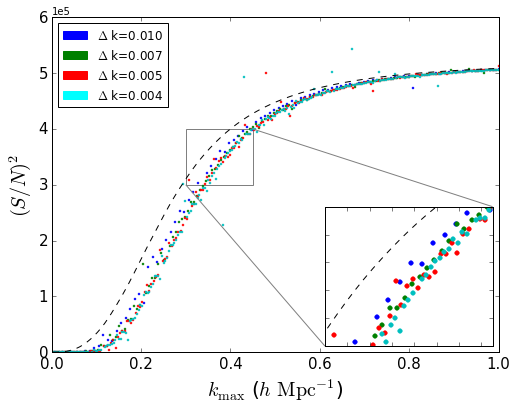

In [81]:
# convergence
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1,1, figsize = (8, 6))

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
axins = zoomed_inset_axes(ax, 2.5, loc=4) 

import glob
txt_filename = glob.glob('data_txt/snr_comparison_dk*')[1:]
label = [txt_filename[i].split("dk")[1].split('.txt')[0] for i in range(len(txt_filename))] 


for i in range(len(txt_filename)):
    dat = np.genfromtxt(txt_filename[i])
    kklist, SNRP, _, SNRXi = dat[:,0], dat[:,1], dat[:,2], dat[:,3]
    print kklist.size, SNRP.size
    ax.plot(kklist, SNRXi, '.', markersize = 4., label= 'dk ={:>0.3f}'.format(float(label[i])))
    #ax2.plot(kklist2[i], SNRlist_Xi[i], '.', label='SNRXI, dk={:>0.3f}'.format(dklist[i]))
    axins.plot(kklist, SNRXi,'.', markersize = 9)
    
ax.plot(kklist, SNRP, linestyle = '--', color = 'black')   
axins.plot(kklist, SNRP, linestyle = '--', color = 'black')

ax.set_xscale('linear')
ax.set_yscale('linear')
ax.set_xlabel(r'$k_{\rm max}$ ($h$ $\rm{Mpc}^{-1}$)', size=20)
ax.set_ylim(1e-5, 6e+5)
ax.set_xlim(1e-3, 1)
ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
ax.set_ylabel(r'$(S/N)^2$', size=20)
#ax.set_title('SNR P (dashed) Xi(solid)')

x1, x2, y1, y2 = 0.3, 0.45, 3e5, 4e5 # specify the limits
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits

from mpl_toolkits.axes_grid1.inset_locator import mark_inset
mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="0.5")
plt.yticks(visible=False)
plt.xticks(visible=False)

patch1 = mpatches.Patch(color='blue', label=r'$\Delta$ k={:>0.3f}'.format(float(label[0])))
patch2 = mpatches.Patch(color='green', label=r'$\Delta$ k={:>0.3f}'.format(float(label[1])))
patch3 = mpatches.Patch(color='red', label=r'$\Delta$ k={:>0.3f}'.format(float(label[2])))
patch4 = mpatches.Patch(color='cyan',label=r'$\Delta$ k={:>0.3f}'.format(float(label[3])))
#patch5 = mpatches.Patch(color='purple',label=r'$\Delta$ k={:>0.3f}'.format(float(label[4])))
ax.legend(handles=[patch1, patch2, patch3, patch4], loc='best')

ax.tick_params(labelsize=15)
#ax.legend(loc='best')
figname='figure/snr_convergence.pdf'
fig.savefig(figname)
print 'fig save to', figname

In [130]:
np.sqrt(SNRXi)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


array([             nan,   3.64875007e-04,   3.81059225e-04,
         3.41441100e-04,   4.20921152e-04,              nan,
                    nan,   4.15181956e-04,              nan,
                    nan,   7.33035912e-04,   4.12470118e-03,
         2.50775249e-03,   8.77592422e-03,   7.83572976e-02,
         1.01674124e-01,   1.35569585e-01,   2.76775631e-01,
         3.89767872e-01,   1.31169270e+00,   2.47000056e+00,
                    nan,              nan,   5.69950295e+01,
         5.31597736e+01,   5.35499522e+01,   5.72506884e+01,
         6.09109002e+01,              nan,   9.33317923e+01,
         1.02461973e+02,   1.13426243e+02,   1.14861155e+02,
         1.18874338e+02,   1.30027832e+02,   1.47003432e+02,
         1.76538870e+02,   1.53059171e+02,   1.50799622e+02,
         1.92365430e+02,   1.91109253e+02,   1.86769492e+02,
         1.46182340e+02,   2.37551416e+02,   2.40706085e+02,
         2.42147193e+02,   2.46166293e+02,   2.60400056e+02,
         2.76486026e+02,

499 499
fig save to figure/SNR_convergence_1.pdf


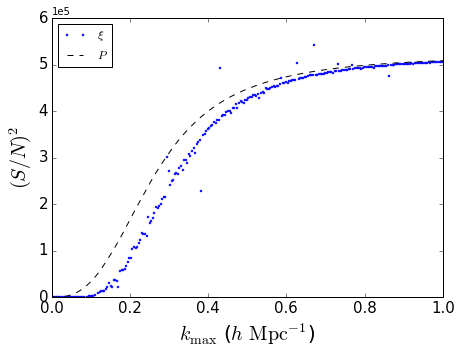

In [145]:
# convergence

fig, ax = plt.subplots(1,1, figsize = (7, 5))
import glob
txt_filename = glob.glob('data_txt/snr_comparison_dk*')
label = [txt_filename[i].split("dk")[1].split('.txt')[0] for i in range(len(txt_filename))] 


#for i in range(len(txt_filename)):
dat = np.genfromtxt(txt_filename[4])
kklist, SNRP, _, SNRXi = dat[:,0], dat[:,1], dat[:,2], dat[:,3]
print kklist.size, SNRP.size
ax.plot(kklist, SNRXi, '.', markersize = 4., label= r'$\xi$')
#ax2.plot(kklist2[i], SNRlist_Xi[i], '.', label='SNRXI, dk={:>0.3f}'.format(dklist[i]))
ax.plot(kklist, SNRP, linestyle = '--', color = 'black', label = r'$P$')   

ax.set_xscale('linear')
ax.set_yscale('linear')
ax.set_xlabel(r'$k_{\rm max}$ ($h$ $\rm{Mpc}^{-1}$)', size=20)
ax.set_ylim(1e-5, 6e+5)
ax.set_xlim(1e-3, 1)
ax.tick_params(labelsize=15)
ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
ax.set_ylabel(r'$(S/N)^2$', size=20)
#ax.set_title('SNR P (dashed) Xi(solid)')

#patch5 = mpatches.Patch(color='blue',label=r'$\Delta$ k={:>0.3f}'.format(float(label[4])))
#ax.legend(handles=[patch5,line], loc=2)
ax.legend(loc='best')
figname='figure/SNR_convergence_1.pdf'
fig.savefig(figname)
print 'fig save to', figname

### Delta SNR 

In [9]:
def snr_interpolation(kbin2, SNR_Xi, k_pred = None, sigf = 1e-6):

    from sklearn.gaussian_process import GaussianProcess

    outlier_mask = np.ones(kbin2.size, dtype=bool)
    
    for i in range(1, kbin2.size):
        if (SNR_Xi[i] < SNR_Xi[i-1]): outlier_mask[i-1] = 0
        if (SNR_Xi[i] < SNR_Xi[i-1]): outlier_mask[i] = 0
        if (SNR_Xi[i] < 0.0): outlier_mask[i] = 0 
    #outlier_mask = outlier_mask * (SNR_Xi < 0) 
    kbin_m = kbin2[outlier_mask]
    SNR_Xi_m = SNR_Xi[outlier_mask]
    
    #------------------------------------------------------------
    # Generate data
    #z_sample, mu_sample = kbin_m[kbin_m.size/30:], SNR_Xi_m[kbin_m.size/30:]
    z_sample, mu_sample = kbin_m, SNR_Xi_m
    
    #outlier_mask = (mu_sample > -100) & (mu_sample < 550000)
    

    dmu = mu_sample * sigf
    #dmu = mu_sample * 1./ mu_sample.max()
    #dmu[dmu.size/20:dmu.size/10] = dmu[dmu.size/20:dmu.size/10] /10
    #dmu[:dmu.size/30] = dmu[:dmu.size/30] * 5
    
    #z = np.linspace(0, 2, 1000)
    #mu_true = np.asarray(map(cosmo.mu, z))

    #------------------------------------------------------------
    # fit the data
    # Mesh the input space for evaluations of the real function,
    # the prediction and its MSE
    #z_fit = np.linspace(0, 2, 1000)
    gp = GaussianProcess(corr='squared_exponential', theta0=1e-1,
                         thetaL=1e-2, thetaU=1,
                         normalize=False,
                         nugget= (dmu / mu_sample) ** 2,
                         random_start=1)
    gp.fit(z_sample[:, None], mu_sample)
    
    kbin3 = np.linspace(KMIN, KMAX, kN_y)
    
    if k_pred is not None : kbin3 = k_pred
    y_pred, MSE = gp.predict(kbin3[:, None], eval_MSE=True)    
    #y_pred, MSE = gp.predict(kcenter[:,None], eval_MSE=True)
    sigma = np.sqrt(MSE)
    
    
    
    
    #y_pred[:kbin_m.size/10] = SNR_Xi_m[:kbin_m.size/10]
    #y_pred[:30] = SNR_Xi_m[:30]
    
    
    """
    
    #------------------------------------------------------------
    # Generate data - small k 
    z_sample2, mu_sample2 = kbin_m[:kbin_m.size/15], SNR_Xi_m[:kbin_m.size/15]
    print kbin_m[kbin_m.size/15]
    dmu = mu_sample2 * 1./ mu_sample2.max()

    # -------------------
    # optimize curve_fit
    # 
    #def func(x, a, b): return a*x**b 
    def func(x, a, b, c): return a*np.exp(b*x-c) - 1
    
    x0 = np.array([1.0, 3.0, 10.0])
    s = (dmu / mu_sample2) ** 2
    import scipy.optimize as optimization
    [a, b, c], cov = optimization.curve_fit(func, z_sample2, mu_sample2, x0, s)
    y_fit = func(kbin2[:kbin2.size/20], a, b, c)
    
    #y_pred[:kbin2.size/20] = y_fit
    """

    
    
    #y_pred[:kbin_m.size/18] = SNR_Xi_m[:kbin_m.size/18]
    return kbin3, y_pred, sigma #,kbin2[:kbin2.size/20], y_fit

In [89]:
#calling data
#DAT = np.loadtxt('data_txt/snr.txt')
DAT = np.loadtxt('data_txt/snr_rmax200_rmin2.txt')
kbin, SNR_P, kbin2, SNR_Xi = [DAT[:,i] for i in range(DAT[0,:].size)]
kbin3, y_pred, sigma  = snr_interpolation(kbin2, SNR_Xi)
print kbin3.shape, y_pred.shape, sigma.shape

DAT = np.loadtxt('data_txt/snr_tot_rmax200_rmin2.txt')
kbin_tot, SNR_tot = [DAT[:,i] for i in range(DAT[0,:].size)]
#kbin_t, y_pred_tot, sigma  = snr_interpolation(kbin_tot, SNR_tot)

(500,) (500,) (500,)


In [90]:
#calling data
#DAT = np.loadtxt('data_txt/snr.txt')
DAT = np.loadtxt('data_txt/snr_diag_rmax200_rmin10.txt')
kbin_d, DiagCSNR_P, DiagCSNR_Xi = [DAT[:,i] for i in range(DAT[0,:].size)]
#kbin3_d, y_pred_d, sigma_d  = snr_interpolation(kbin_d, DiagCSNR_Xi)

IOError: [Errno 2] No such file or directory: 'data_txt/snr_diag_rmax200_rmin10.txt'

(-100000, 600000)

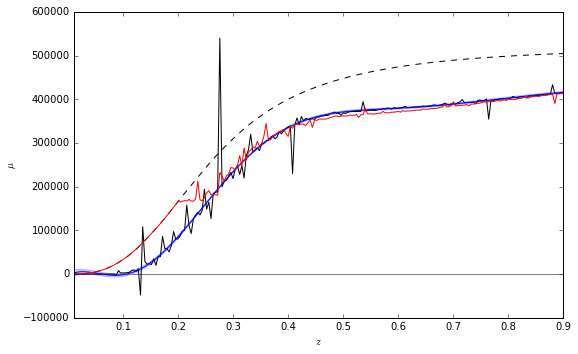

In [581]:
#------------------------------------------------------------
# Plot the gaussian process
#  gaussian process allows computation of the error at each point
#  so we will show this as a shaded region

fig = plt.figure(figsize=(8, 5))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.95)
ax = fig.add_subplot(111)
            

ax.axhline(y=0.0, color = 'grey')
ax.plot(kbin, SNR_P, '--k')
ax.errorbar(kbin, SNR_Xi, None, fmt='-k', ecolor='gray', markersize=1)
ax.plot(kbin3, y_pred, '-b')
#ax.plot(kbin_d, DiagCSNR_Xi, '--b')
ax.plot(kbin_tot, SNR_tot, '-r')
#ax.plot(z_sample2, y_fit, '-r')
#ax.plot(kbin3, y_fit, '-r')
ax.fill_between(kbin3, y_pred - 5 * sigma, y_pred + 5 * sigma,
                alpha=0.2, color='b', label='95% confidence interval')

ax.set_xlabel('$z$')
ax.set_ylabel(r'$\mu$')
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlim(0.01 , 0.9)
ax.set_ylim(-100000, 600000)


In [39]:
#from scipy.interpolate import interp1d
from scipy import interpolate

SNR_P_ftn = interpolate.InterpolatedUnivariateSpline(kbin, SNR_P)
SNR_Xi_ftn = interpolate.InterpolatedUnivariateSpline(kbin3, y_pred)

#kbin2, SNR_P_ftn, sigma = snr_interpolation(kbin, SNR_P)
#kbin2, SNR_Xi_ftn, sigma = snr_interpolation(kbin2, SNR_Xi)

k, s = np.linspace(KMIN, KMAX, kN_y, retstep = True)
kcenter = k[:-1] + s/2.

SNR_P_interp = SNR_P_ftn(kcenter) 
SNR_Xi_interp = SNR_Xi_ftn(kcenter)

DSNR_P_interp = [SNR_P_interp[i]-SNR_P_interp[i-1] for i in range(1, SNR_P_interp.size)]
DSNR_P_interp = np.insert(DSNR_P_interp, 0, SNR_P_interp[0])
DSNR_Xi_interp = [SNR_Xi_interp[i]-SNR_Xi_interp[i-1] for i in range(1, SNR_Xi_interp.size)]
DSNR_Xi_interp = np.insert(DSNR_Xi_interp, 0, SNR_Xi_interp[0])

In [40]:
DiagCSNR_P_ftn = interpolate.InterpolatedUnivariateSpline(kbin_d, DiagCSNR_P)
DiagCSNR_Xi_ftn = interpolate.InterpolatedUnivariateSpline(kbin_d, DiagCSNR_Xi)

DiagCSNR_P = DiagCSNR_P_ftn(kcenter)
DiagCSNR_Xi = DiagCSNR_Xi_ftn(kcenter)

#DiagCSNR_Xi0_ftn = interpolate.InterpolatedUnivariateSpline(RSDPower.kcenter_y, DiagCSNR_Xi0)
#DiagCSNR_Xi0 = DiagCSNR_Xi0_ftn(kcenter)

DiagSNR_P = [DiagCSNR_P[i]-DiagCSNR_P[i-1] for i in range(1, DiagCSNR_P.size)]
DiagSNR_P = np.insert(DiagSNR_P, 0, DiagCSNR_P[0])
DiagSNR_Xi = [DiagCSNR_Xi[i]-DiagCSNR_Xi[i-1] for i in range(1, DiagCSNR_Xi.size)]
DiagSNR_Xi = np.insert(DiagSNR_Xi, 0, DiagCSNR_Xi[0])
#DiagSNR_Xi0 = [DiagCSNR_Xi0[i]-DiagCSNR_Xi0[i-1] for i in range(1, DiagCSNR_Xi0.size)]
#DiagSNR_Xi0 = np.insert(DiagSNR_Xi0, 0, DiagCSNR_Xi0[0])


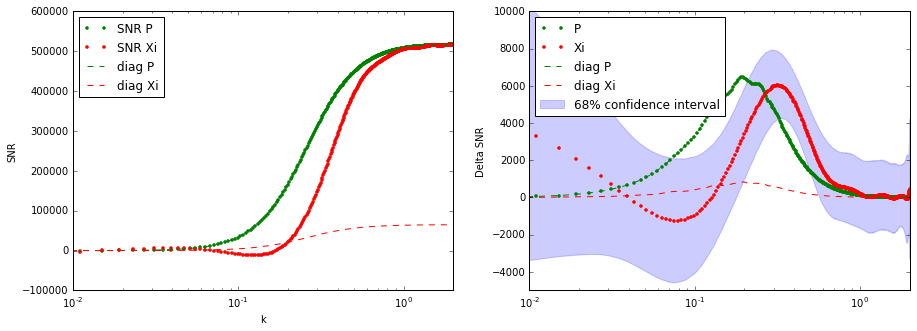

In [42]:
fig, (ax, ax2) = plt.subplots(1,2, figsize = (15, 5))

#ax.plot(kbin, SNR_P, 'k-')#,  label = 'SNRPP')
#ax.plot(kbin2, SNR_Xi, 'k.', markersize = 1.)#, label='SNRXI')
#ax.plot(kbin2, DSNR_tot, linestyle = '-.', color = 'blue', label='SNR tot')

#ax.plot(, SNR_Xi_interp,'r.')
ax.plot(kcenter, SNR_P_interp,'g.',label = 'SNR P')
#ax.plot(kcenter, SNR_Xi_interp,'g^')
ax.plot(kcenter, SNR_Xi_interp,'r.',label = 'SNR Xi')
ax.plot(kcenter, DiagCSNR_P,'g--',label = 'diag P')
ax.plot(kcenter, DiagCSNR_Xi,'r--',label = 'diag Xi')
#ax.plot(kcenter, DiagCSNR_Xi0,'c--',label = 'diag Xi0')
#ax.plot(kcenter, SNR_P_mean,'k.')
#ax2.plot(kbin, DSNR, linestyle = '-', color = 'blue', label = 'SNRPP')
#ax2.plot(kbin2, DSNR_Xi, 'b.',markersize = 2., label='SNRXI')


#ax2.plot(kcenter, DSNR_P_mean, 'k.', label='interp')
ax2.plot(kcenter, DSNR_P_interp, 'g.', label='P')
ax2.plot(kcenter, DSNR_Xi_interp, 'r.', label='Xi')
ax2.plot(kcenter, DiagSNR_P, 'g--', label='diag P')
ax2.plot(kcenter, DiagSNR_Xi, 'r--', label='diag Xi')

ax2.fill_between(kcenter, DSNR_Xi_interp - sigma[:-1], DSNR_Xi_interp + sigma[:-1],
                alpha=0.2, color='b', label='68% confidence interval')

ax.set_xscale('log')
ax2.set_xscale('log')
ax.set_yscale('linear')
ax.set_xlabel('k')
ax.set_ylim(-100000,600000)
ax2.set_ylim( -5000 , 10000)
ax.set_xlim(1e-2, 2)
ax2.set_xlim(1e-2, 2)
ax.set_ylabel('SNR')
ax2.set_ylabel('Delta SNR')
ax.legend(loc='best')
ax2.legend(loc='best')

> Fig2. Cumulative SNR (left) and Delta SNR (right)

## Different Rmax 

In [10]:
def DSNR_interp( kbin, SNR_P, kbin2, y_pred ):
    
    #DAT = np.loadtxt('data_txt/snr_rmax400.txt')
    #kbin, SNR_P, kbin2, SNR_Xi = [DAT[:,i] for i in range(DAT[0,:].size)]
    #kbin2, y_pred, sigma = snr_interpolation(kbin2, SNR_Xi)

    #from scipy.interpolate import interp1d
    from scipy import interpolate
    #"""
    
    SNR_P_ftn = interpolate.InterpolatedUnivariateSpline(kbin, SNR_P)
    SNR_Xi_ftn = interpolate.InterpolatedUnivariateSpline(kbin2, y_pred)

    k, s = np.linspace(KMIN, KMAX, kN_y, retstep = True)
    kcenter = k[:-1] + s/2.

    SNR_P_interp = SNR_P_ftn(kcenter) 
    SNR_Xi_interp = SNR_Xi_ftn(kcenter)
    #"""
    
    #SNR_P_interp = SNR_P
    #SNR_Xi_interp = y_pred
    #kcenter = kbin   
    
    
    DSNR_P_interp = [SNR_P_interp[i]-SNR_P_interp[i-1] for i in range(1, SNR_P_interp.size)]
    DSNR_P_interp = np.insert(DSNR_P_interp, 0, SNR_P_interp[0])
    DSNR_Xi_interp = [SNR_Xi_interp[i]-SNR_Xi_interp[i-1] for i in range(1, SNR_Xi_interp.size)]
    DSNR_Xi_interp = np.insert(DSNR_Xi_interp, 0, SNR_Xi_interp[0])
    
    return kcenter, DSNR_P_interp, DSNR_Xi_interp

1215.05124696
1210.53370417
1208.42628465
1207.2330083


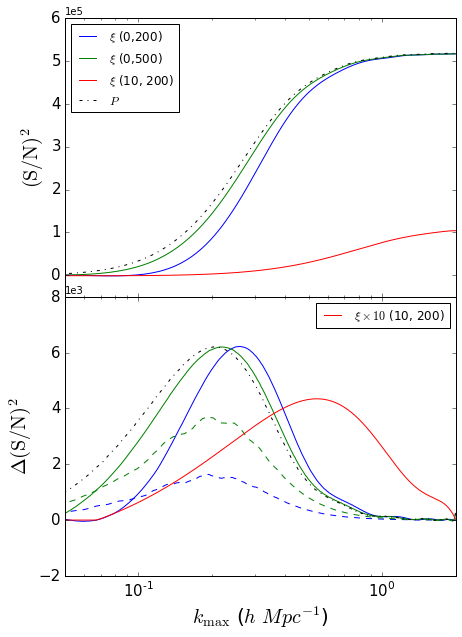

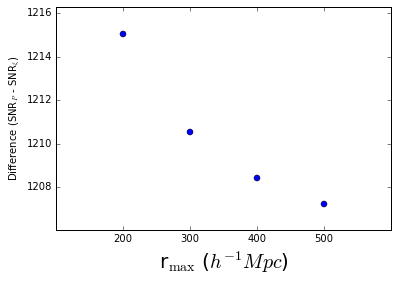

In [745]:
#calling data
#DAT = np.loadtxt('data_txt/snr.txt')
file_num = ['200', '500']
#DATs = [np.loadtxt('data_txt/snr_rmax'+n+'.txt') for n in file_num]

fig, (ax, ax2) = plt.subplots(2,1, figsize = (7, 10))
#fig2, ax2 = plt.subplots(1,1, figsize = (7, 5))
for j, n in enumerate(file_num):
    D1 = np.loadtxt('data_txt/snr_rmax'+n+'_rmin0.txt')
    #D1 = np.genfromtxt('data_txt/snr_comparison_rmin0_rmax'+n+'.txt')
    D2 = np.loadtxt('data_txt/snr_diag_rmax'+n+'_rmin0.txt')
    #D3 = np.loadtxt('data_txt/snr_tot_rmax'+n+'_rmin0.txt')
    #D3 = np.loadtxt('data_txt/snr_tot_rmax'+n+'_rmin0.txt')
    
    #general ----------------------------
    kbin, SNR_P, kbin2, SNR_Xi = [D1[:,i] for i in range(D1[0,:].size)]
    kbin, SNR_P, _  = snr_interpolation(kbin, SNR_P)
    kbin3, y_pred, sigma = snr_interpolation(kbin2[3:], SNR_Xi[3:], sigf=1e-6)   


    kcenter, DSNR_P_interp, DSNR_Xi_interp = DSNR_interp( kbin, SNR_P, kbin3, y_pred )
    
    #diagonal ----------------------------
    kbin_d, DiagCSNR_P, DiagCSNR_Xi = [D2[:,i] for i in range(D2[0,:].size)]
    kbin3_d, y_pred_d, sigma_d  = snr_interpolation(kbin_d, DiagCSNR_Xi)
    kcenter_d, DSNR_P_interp_d, DSNR_Xi_interp_d = DSNR_interp( kbin_d, DiagCSNR_P, kbin_d, DiagCSNR_Xi )
    
        
    if n is '200':
        addition = np.linspace(0, 700, 30)[::-1]       
        DSNR_Xi_interp[:30] = DSNR_Xi_interp[:30] + addition
        
    # total ----------------------------
    #kbin_tot, SNR_tot = [D3[:,i] for i in range(D3[0,:].size)]
    #kbin_tot, SNR_tot, _  = snr_interpolation(kbin_tot, SNR_tot)
    #kcenter_t, _, DSNR_tot = DSNR_interp( kbin_tot, SNR_tot, kbin_tot, SNR_tot )
    #ax.plot(kcenter, DSNR_P_interp,'g.',label = 'DSNR P')
    
    # plot ----------------------------
    ax.plot(kbin3, y_pred, label = r'$\xi$ (0,'+file_num[j] +')' )
    #ax.plot(kbin_tot, SNR_tot, label = r'$tot$ '+ file_num[j])
    #ax.plot(kbin_d, DiagCSNR_Xi, color = ax.lines[-1].get_color() ,linestyle = '--')
    #ax.fill_between(kbin3, y_pred - sigma, y_pred + sigma,
    #            alpha=0.1, color = ax.lines[-1].get_color())
    
    ax2.plot(kcenter, DSNR_Xi_interp)
    #ax2.fill_between(kcenter, DSNR_Xi_interp - sigma[:-1], DSNR_Xi_interp + sigma[:-1],
    #            alpha=0.1, color = ax2.lines[-1].get_color())
    ax2.plot(kcenter_d, DSNR_Xi_interp_d, color = ax.lines[-1].get_color() ,linestyle = '--')
    #ax2.plot(kcenter_t, DSNR_tot, label = r'$tot$ '+ file_num[j])

    
# tot 
D3 = np.loadtxt('data_txt/snr_comparison_rmin10_rmax200.txt')
_, _, kbin2, SNR_Xi = [D3[:,i] for i in range(D3[0,:].size)]
kbin_tot, SNR_tot, _  = snr_interpolation(kbin2, SNR_Xi, sigf=1e-3)
kcenter_t, _, DSNR_tot = DSNR_interp( kbin_tot,SNR_tot, kbin_tot,SNR_tot)

addition = np.linspace(0, 250, 17)[::-1]       
DSNR_tot[:17] = 0 # DSNR_tot[:15] + addition
        
#ax.plot(kbin2, SNR_Xi, '.', markersize = 1, color = 'black')
ax.plot(kbin_tot, SNR_tot, color = 'red',label = r'$\xi$ (10, 200)' )
ax2.plot(kcenter_t, 10*DSNR_tot, color = 'red', label = r'$\xi \times 10$ (10, 200)')
#----------------------------------------


ax.plot(kbin, SNR_P, 'k-.', label = r'$P$')
ax2.plot(kcenter, DSNR_P_interp, 'k-.')   
#ax.plot(kcenter, DiagCSNR_P,'g--',label = 'diag P')
#ax.plot(kcenter, DiagCSNR_Xi,'r--',label = 'diag Xi')
#ax.plot(kcenter, DiagCSNR_Xi0,'c--',label = 'diag Xi0')
#ax.plot(kcenter, SNR_P_mean,'k.')
#ax2.plot(kbin, DSNR, linestyle = '-', color = 'blue', label = 'SNRPP')
#ax2.plot(kbin2, DSNR_Xi, 'b.',markersize = 2., label='SNRXI')

#ax2.plot(kcenter, DSNR_P_mean, 'k.', label='interp')
#ax2.plot(kcenter, DSNR_P_interp, 'g.', label='P')
#ax2.plot(kcenter, DSNR_Xi_interp, 'r.', label='Xi')
#ax2.plot(kcenter, DiagSNR_P, 'g--', label='diag P')
#ax2.plot(kcenter, DiagSNR_Xi, 'r--', label='diag Xi')

ax.set_xscale('log')
ax2.set_xscale('log')
ax.set_yscale('linear')
ax.set_xlabel(r'$k_{\rm max}$ ($h$ $Mpc^{-1}$)', size=20)
ax2.set_xlabel(r'$k_{\rm max}$ ($h$ $Mpc^{-1}$)', size=20)
ax.set_ylim(-50000,600000)
ax2.set_ylim( -2000 , 8000)
ax.set_xlim(5e-2, 2)
ax2.set_xlim(5e-2, 2)
ax.set_ylabel(r'${\rm (S/N)^2}$', size=20)
ax2.set_ylabel(r'$\Delta {\rm (S/N)^2}$', size=20)
ax.legend(loc='best')
ax2.legend(loc='best')
#ax2.legend(loc='best')
ax.tick_params(labelsize=15)
ax2.tick_params(labelsize=15)
ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
ax2.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
plt.subplots_adjust(wspace=0, hspace=0)
fig.savefig('figure/snr_comparison3.pdf')

# --------------------------------
# CSNR_P - CSNR_Xi



file_num = ['200','300','400', '500']
DATs = [np.loadtxt('data_txt/snr_rmax'+n+'_rmin0.txt') for n in file_num]
Difference = np.zeros(len(DATs))
fig, ax = plt.subplots()
for j, D in enumerate(DATs):
    kbin, SNR_P, kbin2, SNR_Xi = [D[:,i] for i in range(D[0,:].size)]
    Difference[j] = SNR_P[-1] - SNR_Xi[-1]
    print SNR_P[-1] - SNR_Xi[-1]


ax.plot( np.arange(len(DATs)), Difference, 'o')
ax.get_xaxis().set_ticks(np.arange(len(DATs)))
ax.get_xaxis().set_ticklabels(file_num)
ax.set_xlabel(r'r$_{\rm max}$ ($h^{-1} Mpc$)', size=20) 
ax.set_ylabel(r'Difference (SNR$_P$ - SNR$_\xi$)', size=10)
ax.set_xlim(-1, len(DATs))
ax.set_ylim(Difference.min() * 0.999, Difference.max() * 1.001)
fig.savefig('figure/difference.pdf')




## fig3 _ optimal estimator 

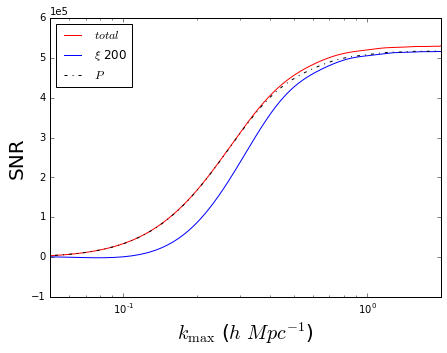

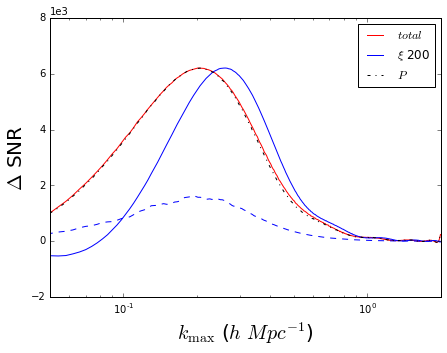

In [116]:
#calling data
#DAT = np.loadtxt('data_txt/snr.txt')
file_num = ['200']
#DATs = [np.loadtxt('data_txt/snr_rmax'+n+'.txt') for n in file_num]

fig, ax = plt.subplots(1,1, figsize = (7, 5))
fig2, ax2 = plt.subplots(1,1, figsize = (7, 5))
for j, n in enumerate(file_num):
    D1 = np.loadtxt('data_txt/snr_rmax'+n+'_rmin0.txt')
    D2 = np.loadtxt('data_txt/snr_diag_rmax'+n+'_rmin0.txt')
    D3 = np.loadtxt('data_txt/snr_tot_rmax'+n+'_rmin0.txt')
    
    #general ----------------------------
    kbin, SNR_P, kbin2, SNR_Xi = [D1[:,i] for i in range(D1[0,:].size)]
    kbin, SNR_P, _  = snr_interpolation(kbin, SNR_P)
    
    kbin3, y_pred, sigma = snr_interpolation(kbin2, SNR_Xi)
    kcenter, DSNR_P_interp, DSNR_Xi_interp = DSNR_interp( kbin, SNR_P, kbin3, y_pred )
    
    #diagonal ----------------------------
    kbin_d, DiagCSNR_P, DiagCSNR_Xi = [D2[:,i] for i in range(D2[0,:].size)]
    #kbin3_d, y_pred_d, sigma_d  = snr_interpolation(kbin_d, DiagCSNR_Xi)
    kcenter_d, DSNR_P_interp_d, DSNR_Xi_interp_d = DSNR_interp( kbin_d, DiagCSNR_P, kbin_d, DiagCSNR_Xi )
    
    # total ----------------------------
    kbin_tot, SNR_tot = [D3[:,i] for i in range(D3[0,:].size)]
    kbin_tot, SNR_tot, _  = snr_interpolation(kbin_tot, SNR_tot)
    kcenter_t, _, DSNR_tot = DSNR_interp( kbin_tot, SNR_tot, kbin_tot, SNR_tot )
    #ax.plot(kcenter, DSNR_P_interp,'g.',label = 'DSNR P')
    
    # plot ----------------------------
    
    ax.plot(kbin_tot, SNR_tot, color = 'red',label = r'$total$' )
    ax.plot(kbin3, y_pred, label = r'$\xi$ '+ file_num[j])
    #ax.plot(kbin_d, DiagCSNR_Xi, color = ax.lines[-1].get_color() ,linestyle = '--')
    #ax.fill_between(kbin3, y_pred - sigma, y_pred + sigma,
    #            alpha=0.1, color = ax.lines[-1].get_color())
    
    ax2.plot(kcenter_t, DSNR_tot, color = 'red', label = r'$total$')
    ax2.plot(kcenter, DSNR_Xi_interp, label=r'$\xi$ '+ file_num[j])
    #ax2.fill_between(kcenter, DSNR_Xi_interp - sigma[:-1], DSNR_Xi_interp + sigma[:-1],
    #            alpha=0.1, color = ax2.lines[-1].get_color())
    ax2.plot(kcenter_d, DSNR_Xi_interp_d, color = ax.lines[-1].get_color() ,linestyle = '--')
    
    
ax.plot(kbin, SNR_P, 'k-.', label = r'$P$')
ax2.plot(kcenter, DSNR_P_interp, 'k-.', label= r'$P$')   
#ax.plot(kcenter, DiagCSNR_P,'g--',label = 'diag P')
#ax.plot(kcenter, DiagCSNR_Xi,'r--',label = 'diag Xi')
#ax.plot(kcenter, DiagCSNR_Xi0,'c--',label = 'diag Xi0')
#ax.plot(kcenter, SNR_P_mean,'k.')
#ax2.plot(kbin, DSNR, linestyle = '-', color = 'blue', label = 'SNRPP')
#ax2.plot(kbin2, DSNR_Xi, 'b.',markersize = 2., label='SNRXI')

#ax2.plot(kcenter, DSNR_P_mean, 'k.', label='interp')
#ax2.plot(kcenter, DSNR_P_interp, 'g.', label='P')
#ax2.plot(kcenter, DSNR_Xi_interp, 'r.', label='Xi')
#ax2.plot(kcenter, DiagSNR_P, 'g--', label='diag P')
#ax2.plot(kcenter, DiagSNR_Xi, 'r--', label='diag Xi')

ax.set_xscale('log')
ax2.set_xscale('log')
ax.set_yscale('linear')
ax.set_xlabel(r'$k_{\rm max}$ ($h$ $Mpc^{-1}$)', size=20)
ax2.set_xlabel(r'$k_{\rm max}$ ($h$ $Mpc^{-1}$)', size=20)
ax.set_ylim(-100000,600000)
ax2.set_ylim( -2000 , 8000)
ax.set_xlim(5e-2, 2)
ax2.set_xlim(5e-2, 2)
ax.set_ylabel('SNR', size=20)
ax2.set_ylabel(r'$\Delta$ SNR', size=20)
ax.legend(loc='best')
ax2.legend(loc='best')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
ax2.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
fig.savefig('figure/snr_comparison_tot.pdf')


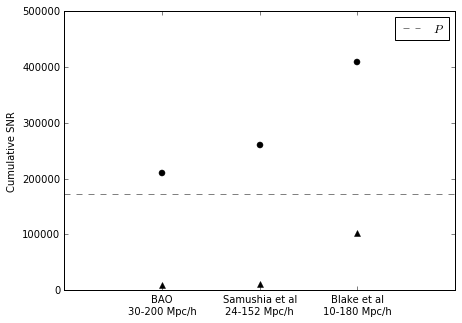

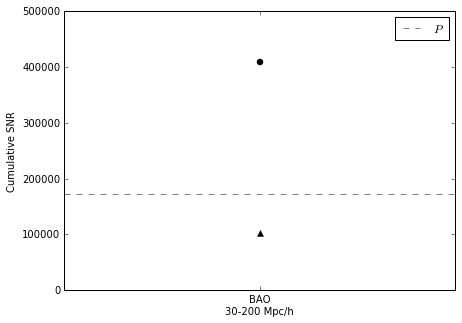

In [149]:
r_range = [['200', '30'], ['152', '24'], ['180', '10']]


fig, ax = plt.subplots(1,1, figsize = (7, 5))
for j, r in enumerate(r_range):
    D1 = np.loadtxt('data_txt/snr_rmax'+r[0]+'_rmin'+r[1]+'.txt')
    D2 = np.loadtxt('data_txt/snr_tot_rmax'+r[0]+'_rmin'+r[1]+'_kmax0.2_kmin0.01.txt')
    
    _, _, kbin2, SNR_Xi = [D1[:,i] for i in range(D1[0,:].size)]
    kbin_tot, SNR_tot = [D2[:,i] for i in range(D2[0,:].size)]    
    
    ax.plot(j, SNR_Xi[-1], marker='^', color = 'black')
    ax.plot(j, SNR_tot[-1], marker = 'o', color = ax.lines[-1].get_color())
    #ax.plot(kbin2, SNR_Xi, '--')
    #ax.plot(kbin_tot, SNR_tot, linestyle = '-', color = ax.lines[-1].get_color())

D3 = np.loadtxt('data_txt/snr_kmax0.2_kmin0.01.txt')
kbin, SNR_P = [D3[:,i] for i in range(D3[0,:].size)]
ax.axhline( y = SNR_P[-1], linestyle='--', color = 'grey', label = r'$P$')
ax.set_ylim(0,500000)
ax.set_xlim(-1, j+1)
ax.set_xticks(np.arange(-1, j+1))
ax.set_xticklabels(['', 'BAO\n30-200 Mpc/h', 'Samushia et al\n24-152 Mpc/h', 'Blake et al\n10-180 Mpc/h'])
ax.legend(loc='best')
ax.set_ylabel('Cumulative SNR')
    
r_range = [['180', '10']]

fig, ax = plt.subplots(1,1, figsize = (7, 5))
for j, r in enumerate(r_range):
    D1 = np.loadtxt('data_txt/snr_rmax'+r[0]+'_rmin'+r[1]+'.txt')
    D2 = np.loadtxt('data_txt/snr_tot_rmax'+r[0]+'_rmin'+r[1]+'_kmax0.2_kmin0.01.txt')
    
    _, _, kbin2, SNR_Xi = [D1[:,i] for i in range(D1[0,:].size)]
    kbin_tot, SNR_tot = [D2[:,i] for i in range(D2[0,:].size)]    
    
    ax.plot(j, SNR_Xi[-1], marker='^', color = 'black')
    ax.plot(j, SNR_tot[-1], marker = 'o', color = ax.lines[-1].get_color())
    #ax.plot(kbin2, SNR_Xi, '--')
    #ax.plot(kbin_tot, SNR_tot, linestyle = '-', color = ax.lines[-1].get_color())

D3 = np.loadtxt('data_txt/snr_kmax0.2_kmin0.01.txt')
kbin, SNR_P = [D3[:,i] for i in range(D3[0,:].size)]
ax.axhline( y = SNR_P[-1], linestyle='--', color = 'grey', label = r'$P$')
ax.set_ylim(0,500000)
ax.set_xlim(-1, j+1)
ax.set_xticks(np.arange(-1, j+1))
ax.set_xticklabels(['','BAO\n30-200 Mpc/h', 'Samushia et al\n24-152 Mpc/h', 'Blake et al\n10-180 Mpc/h'])
ax.legend(loc='best')
ax.set_ylabel('Cumulative SNR')

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in sqrt


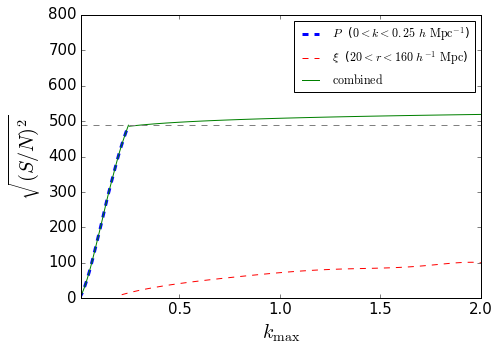

In [21]:
r = ['150', '25']

fig, ax = plt.subplots(1,1, figsize = (7, 5))

# calling data -------------------------------
#for j, r in enumerate(r_range):

D1 = np.loadtxt('data_txt/snr_rmax'+r[0]+'_rmin'+r[1]+'.txt')
D2 = np.loadtxt('data_txt/snr_tot_rmax'+r[0]+'_rmin'+r[1]+'_kmax0.25_kmin1e-10.txt')
D3 = np.loadtxt('data_txt/snr_kmax0.25_kmin1e-10.txt')
kbin, SNR_P = [D3[:,i] for i in range(D3[0,:].size)]
_,_,kbin2, SNR_Xi = [D1[:,i] for i in range(D1[0,:].size)]
kbin_tot, SNR_tot = [D2[:,i] for i in range(D2[0,:].size)]    
  

## fitting-------------------------------

k_pred = np.linspace(0.01, 2.0, 50)
_, y_pred, sigma = snr_interpolation(kbin2, SNR_Xi, k_pred=k_pred)
#kcenter, DSNR_P_interp, DSNR_Xi_interp = DSNR_interp( kbin, SNR_P, kbin3, y_pred )


# snr_tot fitting
def fitfunc(x, a, b):
    #return a*x**2 + b*x+ c
    return a* np.log(x) + b
    #return a*np.exp(x**b)

import scipy
popt, pcov = scipy.optimize.curve_fit(fitfunc, kbin_tot[41:], SNR_tot[41:])


#ax.plot(kbin_tot[:70], np.sqrt(SNR_tot[:70]), 'r-')
k_pred_tot = np.linspace(0.25, 2.0, 30)
#pred_tot = scipy.interpolate.UnivariateSpline(kbin_tot, SNR_tot)
#pred_tot.set_smoothing_factor(0.5)
#plt.plot(k_pred_tot, np.sqrt(pred_tot(k_pred_tot)), 'r-', label='fit')

## plotting-------------------------------

#print k_pred_tot_y

#k_pred_tot_y = scipy.interpolate.spline(kbin_tot[70:], SNR_tot[70:], k_pred_tot, order=3, kind='smoothest', conds=None)
#plt.plot(k_pred_tot, np.sqrt(k_pred_tot_y), 'r-', label='fit')

ax.plot(kbin, np.sqrt(SNR_P), '--', linewidth=3, color = 'blue',label = r'$P$  ($0<k<0.25$ $h$ ${\rm Mpc}^{-1}$)')
#ax.plot(kbin2, np.sqrt(SNR_Xi), '.', markersize=3, color = 'grey', alpha = 0.7)
ax.plot(k_pred, np.sqrt(y_pred), '--', markersize=5, color ='red', label= r'$\xi$  ($20<r<160$ $h^{-1}$ ${\rm Mpc}$)')
#ax.plot(kbin_tot, np.sqrt(SNR_tot), '.', markersize = 3, alpha = 0.7, color= 'grey') #color = ax.lines[-1].get_color())
#ax.plot(k_pred_tot, np.sqrt(y_pred_tot), 'o', markersize=5, color ='black', label= 'interp')

y_pred_tot = fitfunc(k_pred_tot, *popt)
ax.plot(k_pred_tot, np.sqrt(y_pred_tot), 'g-',  label = r'${\rm combined}$')
ax.plot(kbin, np.sqrt(SNR_P), 'g-')

ax.axhline( y = np.sqrt(SNR_P[-1]), linestyle='--', color = 'grey')
ax.legend(loc='best')
ax.set_yscale('linear')
ax.set_xlim(0.01, 2)

ax.set_ylabel(r'$\sqrt{(S/N)^2}$', size =20)
ax.set_xlabel(r'$k_{\rm max}$', size = 20)
ax.set_ylim(0, 800)

ax.tick_params(labelsize=15)
fig.tight_layout()
#fig.savefig('figure/snr_limit_datapoint_logscale.pdf')

In [32]:
kbin_tot[50]

0.10110770824747696

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:47: RuntimeWarning: invalid value encountered in sqrt


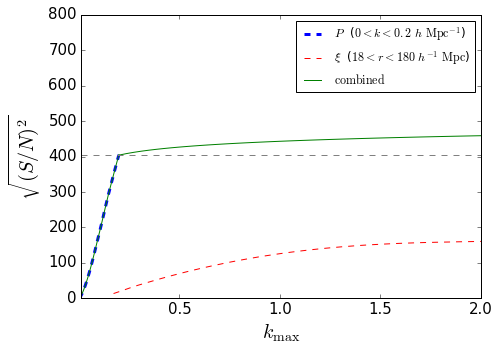

In [61]:
r = ['150', '25']

fig, ax = plt.subplots(1,1, figsize = (7, 5))

# calling data -------------------------------
#for j, r in enumerate(r_range):

D1 = np.loadtxt('data_txt/snr/test_bf_k0_02_kN1000_r18_180_rN162_snr_xi')
D2 = np.loadtxt('data_txt/snr/test_bf_k0_02_kN1000_r18_180_rN162_snr_tot')
D3 = np.loadtxt('data_txt/snr/test_bf_k0_02_kN1000_r18_180_rN162_snr_p')
kbin, SNR_P = [D3[:,i] for i in range(D3[0,:].size)]
kbin2, SNR_Xi = [D1[:,i] for i in range(D1[0,:].size)]
kbin_tot, SNR_tot = [D2[:,i] for i in range(D2[0,:].size)]    

## fitting-------------------------------

k_pred = np.linspace(0.01, 2.0, 50)
_, y_pred, sigma = snr_interpolation(kbin2, SNR_Xi, k_pred=k_pred)
#kcenter, DSNR_P_interp, DSNR_Xi_interp = DSNR_interp( kbin, SNR_P, kbin3, y_pred )


# snr_tot fitting
def fitfunc(x, a, b):
    #return a*x**2 + b*x+ c
    return a* np.log(x) + b
    #return a*np.exp(x**b)

import scipy
popt, pcov = scipy.optimize.curve_fit(fitfunc, kbin_tot[70:], SNR_tot[70:])


#ax.plot(kbin_tot[:70], np.sqrt(SNR_tot[:70]), 'r-')
k_pred_tot = np.linspace(0.2, 2.0, 50)
#pred_tot = scipy.interpolate.UnivariateSpline(kbin_tot, SNR_tot)
#pred_tot.set_smoothing_factor(0.5)
#plt.plot(k_pred_tot, np.sqrt(pred_tot(k_pred_tot)), 'r-', label='fit')

## plotting-------------------------------

#print k_pred_tot_y

#k_pred_tot_y = scipy.interpolate.spline(kbin_tot[70:], SNR_tot[70:], k_pred_tot, order=3, kind='smoothest', conds=None)
#plt.plot(k_pred_tot, np.sqrt(k_pred_tot_y), 'r-', label='fit')

ax.plot(kbin, np.sqrt(SNR_P), '--', linewidth=3, color = 'blue',label = r'$P$  ($0<k<0.2$ $h$ ${\rm Mpc}^{-1}$)')
#ax.plot(kbin2, np.sqrt(SNR_Xi), '.', markersize=3, color = 'grey', alpha = 0.7)
ax.plot(k_pred, np.sqrt(y_pred), '--', markersize=5, color ='red', label= r'$\xi$  ($18<r<180$ $h^{-1}$ ${\rm Mpc}$)')
#ax.plot(kbin_tot, np.sqrt(SNR_tot), '.', markersize = 3, alpha = 0.7, color= 'grey') #color = ax.lines[-1].get_color())
#ax.plot(k_pred_tot, np.sqrt(y_pred_tot), 'o', markersize=5, color ='black', label= 'interp')

y_pred_tot = fitfunc(k_pred_tot, *popt)
ax.plot(k_pred_tot, np.sqrt(y_pred_tot), 'g-',  label = r'${\rm combined}$')
ax.plot(kbin, np.sqrt(SNR_P), 'g-')

ax.axhline( y = np.sqrt(SNR_P[-1]), linestyle='--', color = 'grey')
ax.legend(loc='best')
ax.set_yscale('linear')
ax.set_xlim(0.01, 2)

ax.set_ylabel(r'$\sqrt{(S/N)^2}$', size =20)
ax.set_xlabel(r'$k_{\rm max}$', size = 20)
ax.set_ylim(0, 800)

ax.tick_params(labelsize=15)
fig.tight_layout()
fig.savefig('figure/test_bf_k0_02_kN1000_r18_180_rN162_snr.pdf')

8
(499,)
(8,)


TypeError: Improper input: N=2 must not exceed M=0

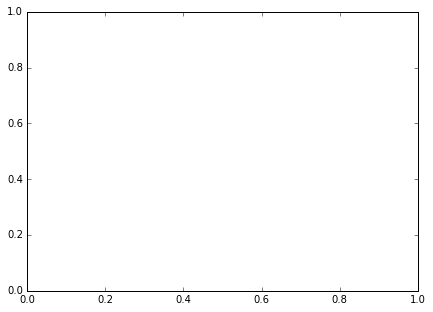

In [82]:
fig, ax = plt.subplots(1,1, figsize = (7, 5))

# calling data -------------------------------
#for j, r in enumerate(r_range):
            
D1 = np.loadtxt('data_txt/snr/test_bf_k0_02_kN500_r18_180_rN162_snr_xi')
D2 = np.loadtxt('data_txt/snr/test_bf_k0_02_kN500_r18_180_rN162_snr_tot')
D3 = np.loadtxt('data_txt/snr/test_bf_k0_02_kN500_r18_180_rN162_snr_p')
kbin, SNR_P = [D3[:,i] for i in range(D3[0,:].size)]
kbin2, SNR_Xi = [D1[:,i] for i in range(D1[0,:].size)]
kbin_tot, SNR_tot = [D2[:,i] for i in range(D2[0,:].size)]    

## fitting-------------------------------

k_pred = np.linspace(0.01, 2.0, 50)
_, y_pred, sigma = snr_interpolation(kbin2, SNR_Xi, k_pred=k_pred)
#kcenter, DSNR_P_interp, DSNR_Xi_interp = DSNR_interp( kbin, SNR_P, kbin3, y_pred )


# snr_tot fitting
def fitfunc(x, a, b):
    #return a*x**2 + b*x+ c
    return a* np.log(x) + b
    #return a*np.exp(x**b)

import scipy
mask = (SNR_tot < 600.0)
print np.sum(mask)

print kbin_tot.shape
kbin_tot = kbin_tot[mask]
SNR_tot = SNR_tot[mask]

print kbin_tot.shape
popt, pcov = scipy.optimize.curve_fit(fitfunc, kbin_tot[30:], SNR_tot[30:])

#ax.plot(kbin_tot[:70], np.sqrt(SNR_tot[:70]), 'r-')
k_pred_tot = np.linspace(0.2, 2.0, 50)
#pred_tot = scipy.interpolate.UnivariateSpline(kbin_tot, SNR_tot)
#pred_tot.set_smoothing_factor(0.5)
#plt.plot(k_pred_tot, np.sqrt(pred_tot(k_pred_tot)), 'r-', label='fit')

## plotting-------------------------------

#print k_pred_tot_y

#k_pred_tot_y = scipy.interpolate.spline(kbin_tot[70:], SNR_tot[70:], k_pred_tot, order=3, kind='smoothest', conds=None)
#plt.plot(k_pred_tot, np.sqrt(k_pred_tot_y), 'r-', label='fit')

ax.plot(kbin, np.sqrt(SNR_P), '--', linewidth=3, color = 'blue',label = r'$P$  ($0<k<0.2$ $h$ ${\rm Mpc}^{-1}$)')
#ax.plot(kbin2, np.sqrt(SNR_Xi), '.', markersize=3, color = 'grey', alpha = 0.7)
ax.plot(k_pred, np.sqrt(y_pred), '--', markersize=5, color ='red', label= r'$\xi$  ($18<r<180$ $h^{-1}$ ${\rm Mpc}$)')
ax.plot(kbin_tot, np.sqrt(SNR_tot), '.', markersize = 3, alpha = 0.7, color= 'grey') #color = ax.lines[-1].get_color())
#ax.plot(k_pred_tot, np.sqrt(y_pred_tot), 'o', markersize=5, color ='black', label= 'interp')

y_pred_tot = fitfunc(k_pred_tot, *popt)
ax.plot(k_pred_tot, np.sqrt(y_pred_tot), 'g-',  label = r'${\rm combined}$')
ax.plot(kbin, np.sqrt(SNR_P), 'g-')

ax.axhline( y = np.sqrt(SNR_P[-1]), linestyle='--', color = 'grey')
ax.legend(loc='best')
ax.set_yscale('linear')
ax.set_xlim(0.01, 2)

ax.set_ylabel(r'$\sqrt{(S/N)^2}$', size =20)
ax.set_xlabel(r'$k_{\rm max}$', size = 20)
ax.set_ylim(0, 800)

ax.tick_params(labelsize=15)
fig.tight_layout()
fig.savefig('figure/test_bf_k0_02_kN500_r18_180_rN162_nn5_snr.pdf')

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:45: RuntimeWarning: invalid value encountered in sqrt


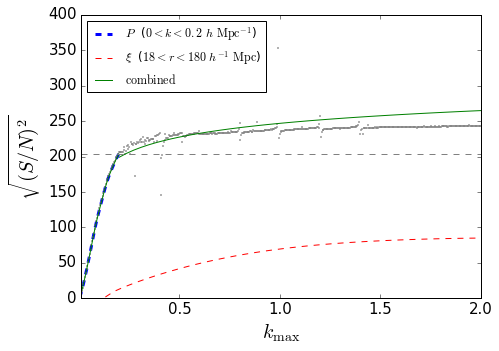

In [70]:
fig, ax = plt.subplots(1,1, figsize = (7, 5))

# calling data -------------------------------
#for j, r in enumerate(r_range):
            
D1 = np.loadtxt('data_txt/snr/test_bf_k0_02_kN500_r18_180_rN162_nn5_snr_xi')
D2 = np.loadtxt('data_txt/snr/test_bf_k0_02_kN500_r18_180_rN162_nn5_snr_tot')
D3 = np.loadtxt('data_txt/snr/test_bf_k0_02_kN500_r18_180_rN162_nn5_snr_p')
kbin, SNR_P = [D3[:,i] for i in range(D3[0,:].size)]
kbin2, SNR_Xi = [D1[:,i] for i in range(D1[0,:].size)]
kbin_tot, SNR_tot = [D2[:,i] for i in range(D2[0,:].size)]    

## fitting-------------------------------

k_pred = np.linspace(0.01, 2.0, 50)
_, y_pred, sigma = snr_interpolation(kbin2, SNR_Xi, k_pred=k_pred)
#kcenter, DSNR_P_interp, DSNR_Xi_interp = DSNR_interp( kbin, SNR_P, kbin3, y_pred )


# snr_tot fitting
def fitfunc(x, a, b):
    #return a*x**2 + b*x+ c
    return a* np.log(x) + b
    #return a*np.exp(x**b)

import scipy
popt, pcov = scipy.optimize.curve_fit(fitfunc, kbin_tot[30:200], SNR_tot[30:200])


#ax.plot(kbin_tot[:70], np.sqrt(SNR_tot[:70]), 'r-')
k_pred_tot = np.linspace(0.2, 2.0, 50)
#pred_tot = scipy.interpolate.UnivariateSpline(kbin_tot, SNR_tot)
#pred_tot.set_smoothing_factor(0.5)
#plt.plot(k_pred_tot, np.sqrt(pred_tot(k_pred_tot)), 'r-', label='fit')

## plotting-------------------------------

#print k_pred_tot_y

#k_pred_tot_y = scipy.interpolate.spline(kbin_tot[70:], SNR_tot[70:], k_pred_tot, order=3, kind='smoothest', conds=None)
#plt.plot(k_pred_tot, np.sqrt(k_pred_tot_y), 'r-', label='fit')

ax.plot(kbin, np.sqrt(SNR_P), '--', linewidth=3, color = 'blue',label = r'$P$  ($0<k<0.2$ $h$ ${\rm Mpc}^{-1}$)')
#ax.plot(kbin2, np.sqrt(SNR_Xi), '.', markersize=3, color = 'grey', alpha = 0.7)
ax.plot(k_pred, np.sqrt(y_pred), '--', markersize=5, color ='red', label= r'$\xi$  ($18<r<180$ $h^{-1}$ ${\rm Mpc}$)')
ax.plot(kbin_tot, np.sqrt(SNR_tot), '.', markersize = 3, alpha = 0.7, color= 'grey') #color = ax.lines[-1].get_color())
#ax.plot(k_pred_tot, np.sqrt(y_pred_tot), 'o', markersize=5, color ='black', label= 'interp')

y_pred_tot = fitfunc(k_pred_tot, *popt)
ax.plot(k_pred_tot, np.sqrt(y_pred_tot), 'g-',  label = r'${\rm combined}$')
ax.plot(kbin, np.sqrt(SNR_P), 'g-')

ax.axhline( y = np.sqrt(SNR_P[-1]), linestyle='--', color = 'grey')
ax.legend(loc='best')
ax.set_yscale('linear')
ax.set_xlim(0.01, 2)

ax.set_ylabel(r'$\sqrt{(S/N)^2}$', size =20)
ax.set_xlabel(r'$k_{\rm max}$', size = 20)
ax.set_ylim(0, 400)

ax.tick_params(labelsize=15)
fig.tight_layout()
fig.savefig('figure/test_bf_k0_02_kN500_r18_180_rN162_nn5_snr.pdf')

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:45: RuntimeWarning: invalid value encountered in sqrt


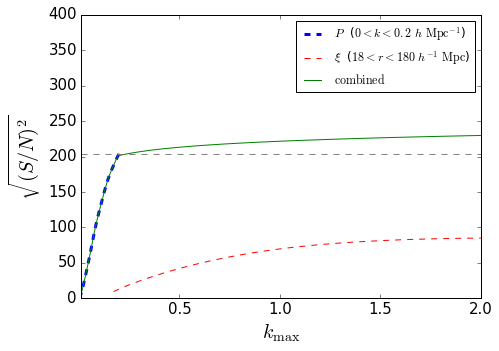

In [55]:
fig, ax = plt.subplots(1,1, figsize = (7, 5))

# calling data -------------------------------
#for j, r in enumerate(r_range):
            
D1 = np.loadtxt('data_txt/snr/test_bf_k0_02_kN1000_r18_180_rN162_nn5_snr_xi')
D2 = np.loadtxt('data_txt/snr/test_bf_k0_02_kN1000_r18_180_rN162_nn5_snr_tot')
D3 = np.loadtxt('data_txt/snr/test_bf_k0_02_kN1000_r18_180_rN162_nn5_snr_p')
kbin, SNR_P = [D3[:,i] for i in range(D3[0,:].size)]
kbin2, SNR_Xi = [D1[:,i] for i in range(D1[0,:].size)]
kbin_tot, SNR_tot = [D2[:,i] for i in range(D2[0,:].size)]    

## fitting-------------------------------

k_pred = np.linspace(0.01, 2.0, 50)
_, y_pred, sigma = snr_interpolation(kbin2, SNR_Xi, k_pred=k_pred)
#kcenter, DSNR_P_interp, DSNR_Xi_interp = DSNR_interp( kbin, SNR_P, kbin3, y_pred )


# snr_tot fitting
def fitfunc(x, a, b):
    #return a*x**2 + b*x+ c
    return a* np.log(x) + b
    #return a*np.exp(x**b)

import scipy
popt, pcov = scipy.optimize.curve_fit(fitfunc, kbin_tot[30:], SNR_tot[30:])


#ax.plot(kbin_tot[:70], np.sqrt(SNR_tot[:70]), 'r-')
k_pred_tot = np.linspace(0.2, 2.0, 50)
#pred_tot = scipy.interpolate.UnivariateSpline(kbin_tot, SNR_tot)
#pred_tot.set_smoothing_factor(0.5)
#plt.plot(k_pred_tot, np.sqrt(pred_tot(k_pred_tot)), 'r-', label='fit')

## plotting-------------------------------

#print k_pred_tot_y

#k_pred_tot_y = scipy.interpolate.spline(kbin_tot[70:], SNR_tot[70:], k_pred_tot, order=3, kind='smoothest', conds=None)
#plt.plot(k_pred_tot, np.sqrt(k_pred_tot_y), 'r-', label='fit')

ax.plot(kbin, np.sqrt(SNR_P), '--', linewidth=3, color = 'blue',label = r'$P$  ($0<k<0.2$ $h$ ${\rm Mpc}^{-1}$)')
#ax.plot(kbin2, np.sqrt(SNR_Xi), '.', markersize=3, color = 'grey', alpha = 0.7)
ax.plot(k_pred, np.sqrt(y_pred), '--', markersize=5, color ='red', label= r'$\xi$  ($18<r<180$ $h^{-1}$ ${\rm Mpc}$)')
#ax.plot(kbin_tot, np.sqrt(SNR_tot), '.', markersize = 3, alpha = 0.7, color= 'grey') #color = ax.lines[-1].get_color())
#ax.plot(k_pred_tot, np.sqrt(y_pred_tot), 'o', markersize=5, color ='black', label= 'interp')

y_pred_tot = fitfunc(k_pred_tot, *popt)
ax.plot(k_pred_tot, np.sqrt(y_pred_tot), 'g-',  label = r'${\rm combined}$')
ax.plot(kbin, np.sqrt(SNR_P), 'g-')

ax.axhline( y = np.sqrt(SNR_P[-1]), linestyle='--', color = 'grey')
ax.legend(loc='best')
ax.set_yscale('linear')
ax.set_xlim(0.01, 2)

ax.set_ylabel(r'$\sqrt{(S/N)^2}$', size =20)
ax.set_xlabel(r'$k_{\rm max}$', size = 20)
ax.set_ylim(0, 400)

ax.tick_params(labelsize=15)
fig.tight_layout()
fig.savefig('figure/test_bf_k0_02_kN1000_r18_180_rN162_nn5_snr.pdf')

In [342]:
kcenter, DSNR_P_interp, DSNR_Xi_interp = DSNR_interp( kbin, SNR_P, k_pred, y_pred )
_, DSNR_P_interp_sqrt, DSNR_Xi_interp_sqrt = DSNR_interp( kbin, np.sqrt(SNR_P), k_pred[6:], np.sqrt(y_pred[6:]) )
#kcenter, DSNR_P_interp, DSNR_Xi_interp = DSNR_interp( kbin, SNR_P, kbin2, SNR_Xi )
#kbin_tot = np.hstack([kbin, k_pred_tot])
#SNR_tot = np.hstack([SNR_P), np.sqrt(y_pred_tot)])
#kcenter_t, _, DSNR_tot = DSNR_interp( kbin_tot, np.sqrt(SNR_tot), kbin_tot, np.sqrt(SNR_tot) )

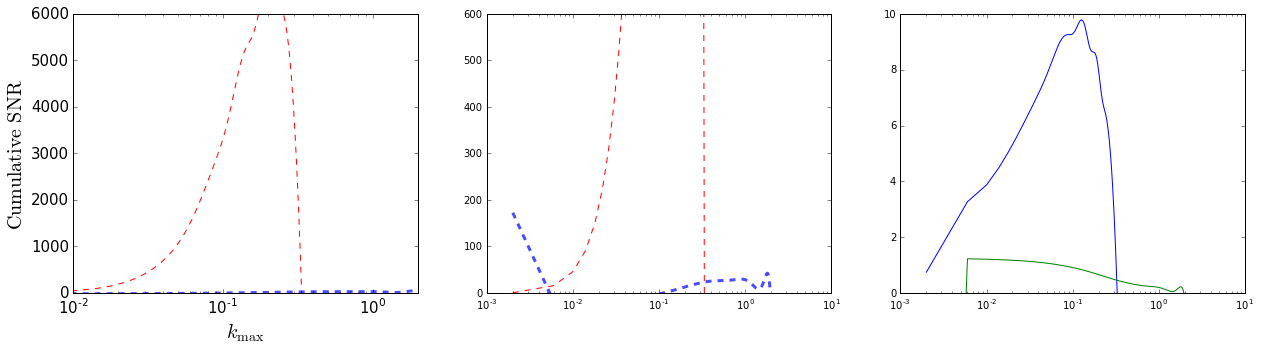

In [351]:
fig, (ax, ax2, ax3) = plt.subplots(1,3,figsize=(21,5))
ax.plot(kcenter, DSNR_P_interp, '--', linewidth=1, color = 'red',label = r'$P$  ($0<k<0.25$ $h$ ${\rm Mpc}^{-1}$)')
ax.plot(kcenter, DSNR_Xi_interp, '--', linewidth=3, color = 'blue', alpha = 0.7)
#ax.plot(kcenter_t, DSNR_tot, '.', markersize = 3, alpha = 0.7, color= 'green') #color = ax.lines[-1].get_color())
#ax.plot(k_pred_tot, np.sqrt(y_pred_tot), 'o', markersize=5, color ='black', label= 'interp')

ax2.plot(kcenter, DSNR_P_interp, '--', linewidth=1, color = 'red',label = r'$P$  ($0<k<0.25$ $h$ ${\rm Mpc}^{-1}$)')
ax2.plot(kcenter, DSNR_Xi_interp, '--', linewidth=3, color = 'blue', alpha = 0.7)
#ax.plot(kcenter_t, DSNR_tot, '.', markersize = 3, alpha = 0.7, color= 'green') #color = ax.lines[-1].get_color())
#ax.plot(k_pred_tot, np.sqrt(y_pred_tot), 'o', markersize=5, color ='black', label= 'interp')


ax3.plot(kcenter, DSNR_P_interp_sqrt)
ax3.plot(kcenter, DSNR_Xi_interp_sqrt)
#ax.axhline( y = np.sqrt(SNR_P[-1]), linestyle='--', color = 'grey')
#ax.legend(loc='best')
ax.set_xscale('log')
ax2.set_xscale('log')
ax3.set_xscale('log')

ax.set_xlim(0.01, 2)
ax.set_ylabel(r'$\rm Cumulative$ $\rm SNR$', size =20)
ax.set_xlabel(r'$k_{\rm max}$', size = 20)
ax.set_ylim(0,6000)
ax2.set_ylim(0,600)
ax3.set_ylim(0,10)

ax.tick_params(labelsize=15)

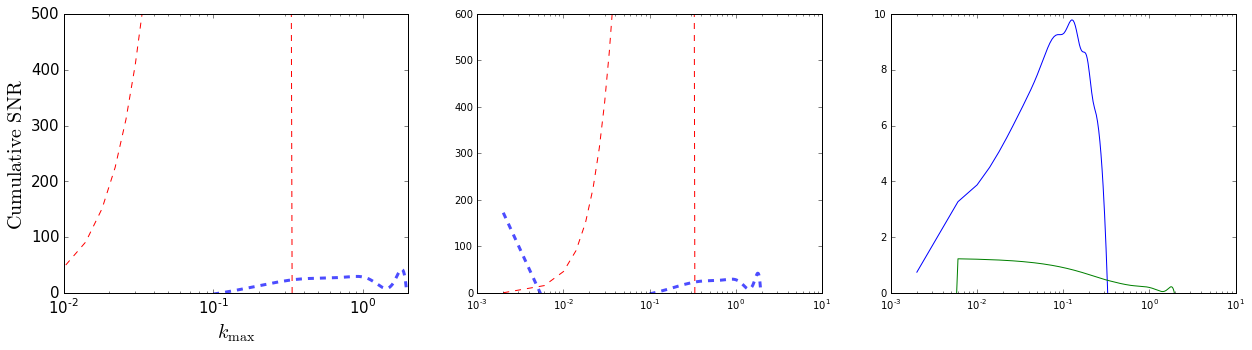

In [356]:
fig, (ax, ax2, ax3) = plt.subplots(1,3,figsize=(21,5))
ax.plot(kcenter, DSNR_P_interp, '--', linewidth=1, color = 'red',label = r'$P$  ($0<k<0.25$ $h$ ${\rm Mpc}^{-1}$)')
ax.plot(kcenter, DSNR_Xi_interp, '--', linewidth=3, color = 'blue', alpha = 0.7)
#ax.plot(kcenter_t, DSNR_tot, '.', markersize = 3, alpha = 0.7, color= 'green') #color = ax.lines[-1].get_color())
#ax.plot(k_pred_tot, np.sqrt(y_pred_tot), 'o', markersize=5, color ='black', label= 'interp')

ax2.plot(kcenter, DSNR_P_interp, '--', linewidth=1, color = 'red',label = r'$P$  ($0<k<0.25$ $h$ ${\rm Mpc}^{-1}$)')
ax2.plot(kcenter, DSNR_Xi_interp, '--', linewidth=3, color = 'blue', alpha = 0.7)
#ax.plot(kcenter_t, DSNR_tot, '.', markersize = 3, alpha = 0.7, color= 'green') #color = ax.lines[-1].get_color())
#ax.plot(k_pred_tot, np.sqrt(y_pred_tot), 'o', markersize=5, color ='black', label= 'interp')


ax3.plot(kcenter, DSNR_P_interp_sqrt)
ax3.plot(kcenter, DSNR_Xi_interp_sqrt)
#ax.axhline( y = np.sqrt(SNR_P[-1]), linestyle='--', color = 'grey')
#ax.legend(loc='best')
ax.set_xscale('log')
ax2.set_xscale('log')
ax3.set_xscale('log')

ax.set_xlim(0.01, 2)
ax.set_ylabel(r'$\rm Cumulative$ $\rm SNR$', size =20)
ax.set_xlabel(r'$k_{\rm max}$', size = 20)
ax.set_ylim(0,500)
ax2.set_ylim(0,600)
ax3.set_ylim(0,10)

ax.tick_params(labelsize=15)

# SNR - CSNR as a function of rmin or rmax

In [106]:
np.linspace(50, 200, 11)

array([  50.,   65.,   80.,   95.,  110.,  125.,  140.,  155.,  170.,
        185.,  200.])

In [113]:
#  (parameter description in class code)
# Fourier K 0.001~10
KMIN = 1e-10
KMAX = 2 # 361.32 #502.32

kmin = KMIN
kmax = KMAX

# the number of k sample point should be 2^n+1 (b/c romb integration)
rN = 100 # (RMAX-int(RMIN)) * 2
kN = 2**10 + 1
kN_x = 1.
kN_y = 500
#subN = 2**5 + 1
# RSD class

In [165]:
np.linspace(20, 100, 5)

array([  20.,   40.,   60.,   80.,  100.])

In [240]:
# varying rmax
# summed over from 0 to rmax
rmaxlist = np.linspace(100, 200, 6)
#rmaxlist = np.linspace(20, 100, 5)
#rmaxlist = [20]
#kklist = []
#SNRlist_P = []
#kklist2 = []
#SNRlist_Xi = []
#SNRlist_tot = []

rmaxlist = [200]
rNN = 201
for rm in rmaxlist:
    
    RSDPower = NoShell_covariance(KMIN, KMAX, 1e-10, rm, kN, rNN, kN_x, kN_y, logscale = False)
    _, kbin, SNR_P, kbin2, SNR_Xi = SNR_P_Xi(RSDPower, kmin = KMIN, kmax = KMAX)
    
    DAT = np.column_stack(( kbin, SNR_P, kbin2, SNR_Xi))
    np.savetxt('data_txt/snr_comparison_rmax{:>0.0f}.txt'.format(rm), DAT,\
               header = ' kbin, SNR_P, kbin2, SNR_Xi, kbin2, SNR_tot ' )
    rNN += 20

-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1025, N_y = 500, rN = 201
dr = 1.0, dk=0.0019531249999, dk_y=0.00400801603186


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %/nFisherXi 0


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


In [241]:
np.linspace(0, 180, 10)

array([   0.,   20.,   40.,   60.,   80.,  100.,  120.,  140.,  160.,  180.])

In [250]:
# varying rmin
# summed over from rmin to rmax = 200
rminlist = np.linspace(0, 180, 10)
#rminlist = np.linspace(100, 180, 5)
rminlist = [0]
rNN = 201
for rn in rminlist:
    print rn
    RSDPower = NoShell_covariance(KMIN, KMAX, rn, 200, kN, rNN, kN_x, kN_y, logscale = False)
    _, kbin, SNR_P, kbin2, SNR_Xi = SNR_P_Xi(RSDPower, kmin = KMIN, kmax = KMAX)
    
    DAT = np.column_stack(( kbin, SNR_P, kbin2, SNR_Xi ))
    np.savetxt('data_txt/snr_comparison_rmin{:>0.0f}.txt'.format(rn), DAT,\
               header = ' kbin, SNR_P, kbin2, SNR_Xi ' )
    rNN-=20

0
-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1025, N_y = 500, rN = 201
dr = 1.0, dk=0.0019531249999, dk_y=0.00400801603186


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

noshellavg.py:528: RuntimeWarning: divide by zero encountered in divide
  22 * k**2 * sin(k * rmin) + (105 * sin(k * rmin))/rmin**2 +\
noshellavg.py:528: RuntimeWarning: invalid value encountered in divide
  22 * k**2 * sin(k * rmin) + (105 * sin(k * rmin))/rmin**2 +\
noshellavg.py:534: RuntimeWarning: divide by zero encountered in divide
  22 * k**2 * sin(k * rmin) + (105 * sin(k * rmin))/rmin**2 +\
noshellavg.py:534: RuntimeWarning: invalid value encountered in divide
  22 * k**2 * sin(k * rmin) + (105 * sin(k * rmin))/rmin**2 +\
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(sha

multiprocessing 100 %/nFisherXi 0


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


In [214]:
np.linspace(20, 200, 10)

array([  20.,   40.,   60.,   80.,  100.,  120.,  140.,  160.,  180.,  200.])

In [474]:
difference_rmin

[99.845138523629032, 20.171876251079834, 3.796360751112938, 1.1800368035404674]

In [475]:
difference_rmax

[99.844559533994328, 99.844743234499802, 99.84491093405947, 99.845138523629032]

In [482]:
print difference_rmax
print difference_rmin

[99.844559533994328, 99.844743234499802, 99.84491093405947, 99.845138523629032]
[99.845138523629032, 20.171876251079834, 3.796360751112938, 1.1800368035404674]


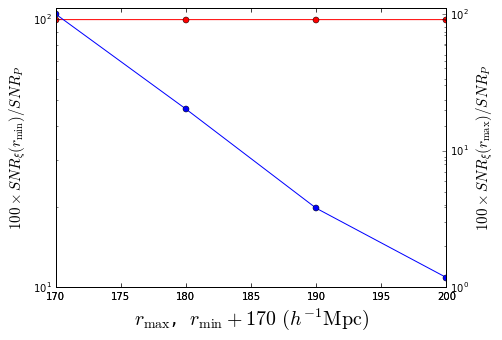

In [550]:
rminlist = [0,10,20,30]
rmaxlist = [170,180,190,200]

#rmaxlist = [200,300,400,500]
difference_rmax = []
difference_rmin = []

for rm, rn in zip(rmaxlist, rminlist):
    
    #snr_data = np.genfromtxt('data_txt/snr_rmax{:>0.0f}_rmin0.txt'.format(rm))
    snr_data = np.genfromtxt('data_txt/snr_comparison_rmax{:>0.0f}.txt'.format(rm))
    k, SP, k2, SX = [snr_data[:,i] for i in range(4)]
    #ax.plot(k2, SX, '.')
    difference_rmax.append(SX[-1]/SP[-1] *100)
    #difference_rmax.append(SX[-1])
    #print 0, rm, SP[-1]-SX[-1], SP[-1], SX[-1]
    snr_data_rmin = np.genfromtxt('data_txt/snr_comparison_rmin{:>0.0f}.txt'.format(rn))
    k, SP, k2, SX = [snr_data_rmin[:,i] for i in range(4)]
    difference_rmin.append(SX[-1]/SP[-1] *100)
    
    #difference_rmin.append(SX[-1])
    #print rn, 200, SP[-1]-SX[-1], SP[-1], SX[-1], '\n'

    
fig, (ax) = plt.subplots(1,1, figsize=(7,5))

ax2 = fig.add_axes(ax.get_position())
ax2.patch.set_visible(False)
ax2.yaxis.set_label_position('right')
ax2.yaxis.set_ticks_position('right')
#ax2.spines['top'].set_position(('outward', 40))

ax2.plot(rmaxlist, difference_rmin, 'bo-', label='rmin < r < 200')
ax2.set_ylabel(r'$100 \times SNR_{\xi}(r_{\rm max})/SNR_P$', size = 15)

#ax2.set_xlabel(r'$r_{\rm min}$', size = 20)

ax.plot(rmaxlist, difference_rmax, 'ro-', label='0 < r < rmax')
#ax.plot(rminlist, difference_rmin, 'bo-', label='rmin < r < 200')
ax.set_ylabel(r'$100 \times SNR_{\xi}(r_{\rm min})/SNR_P$', size = 15)


#ax2 = ax.twinx()

#ax2.set_ylim(99.84,100)
#ax2.set_xlim(-5,40)
ax.set_xlabel(r'$r_{\rm max}$,  $r_{\rm min} + 170$ $(h^{-1} {\rm Mpc})$', size = 20)
#ax.legend(loc = 4)
ax.set_yscale('log')
ax2.set_yscale('log')
#ax2.legend(loc = 4)
ax2.set_ylim(None,110)
ax.set_ylim(None,110)
#fig.tight_layout()
fig.savefig('figure/snr_percentage.pdf')



In [490]:
ls data_txt/snr_rmax*

data_txt/snr_rmax100_rmin0.txt      data_txt/snr_rmax200_rmin2.txt
data_txt/snr_rmax150_rmin25.txt     data_txt/snr_rmax200_rmin30.txt
data_txt/snr_rmax152_rmin24.txt     data_txt/snr_rmax200_rmin55.txt
data_txt/snr_rmax160_rmin20.txt     data_txt/snr_rmax300_rmin0.txt
data_txt/snr_rmax180_rmin10.txt     data_txt/snr_rmax300_rmin24.txt
data_txt/snr_rmax200_rmin0.txt      data_txt/snr_rmax400_rmin0.txt
data_txt/snr_rmax200_rmin10.txt     data_txt/snr_rmax500_rmin0.txt
data_txt/snr_rmax200_rmin1e-10.txt


In [457]:
ls data_txt/snr_comparison_rmax*

data_txt/snr_comparison_rmax0.txt    data_txt/snr_comparison_rmax190.txt
data_txt/snr_comparison_rmax100.txt  data_txt/snr_comparison_rmax200.txt
data_txt/snr_comparison_rmax120.txt  data_txt/snr_comparison_rmax20.txt
data_txt/snr_comparison_rmax140.txt  data_txt/snr_comparison_rmax40.txt
data_txt/snr_comparison_rmax160.txt  data_txt/snr_comparison_rmax60.txt
data_txt/snr_comparison_rmax170.txt  data_txt/snr_comparison_rmax80.txt
data_txt/snr_comparison_rmax180.txt


In [430]:
#1binsinze = RMAX/rN -> rN = RMAX/1binsize

200

In [577]:
#  (parameter description in class code)
# Fourier K 0.001~10
KMIN = 0.001 # 1e-10
KMAX = 2 # 361.32 #502.32
RMIN = 5
RMAX = 200

kmin = KMIN
kmax = KMAX

# the number of k sample point should be 2^n+1 (b/c romb integration)
rN = int((RMAX-RMIN)/0.40060120240) #(RMAX-int(RMIN)) * 2
kN = 2**10 + 1
kN_x = 1.
kN_y = 500
#subN = 2**5 + 1
# RSD class

-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1025, N_y = 500, rN = 486
dr = 0.40206185567, dk=0.0019521484375, dk_y=0.00400601202405


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %/nFisherXi 0


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


(0, 600000.0)

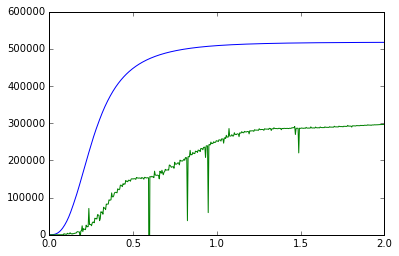

In [578]:
RSDPower = NoShell_covariance(KMIN, KMAX, RMIN, RMAX, kN, rN, kN_x, kN_y, logscale = False)
_, kbin, SNR_P, kbin2, SNR_Xi = SNR_P_Xi(RSDPower, kmin = 1e-10, kmax = 2)
#(RSDPower, kmin = kmin, kmax = kmax)
fig, ax = plt.subplots()
ax.plot(kbin, SNR_P)
ax.plot(kbin2, SNR_Xi)
ax.set_ylim(0,6e+5)

In [579]:
DAT = np.column_stack(( kbin, SNR_P, kbin2, SNR_Xi ))
print 'data_txt/snr_comparison_rmin{:>0.0f}_rmax{:>0.0f}.txt'.format(RMIN, RMAX)
#np.savetxt('data_txt/snr_comparison_rmin{:>0.0f}.txt'.format(RMIN), DAT,\
#           header = ' kbin, SNR_P, kbin2, SNR_Xi ' )
np.savetxt('data_txt/snr_comparison_rmin{:>0.0f}_rmax{:>0.0f}.txt'.format(RMIN, RMAX), DAT,\
           header = ' kbin, SNR_P, kbin2, SNR_Xi ' )

data_txt/snr_comparison_rmin5_rmax200.txt


In [580]:
RMIN, RMAX

(5, 200)

In [ ]:
#cp data_txt/snr_comparison_rmax200.txt data_txt/snr_comparison_rmin0_rmax200.txt

In [ ]:
#cp data_txt/snr_comparison_rmin10.txt data_txt/snr_comparison_rmin10_rmax200.txt

(0, 600000.0)

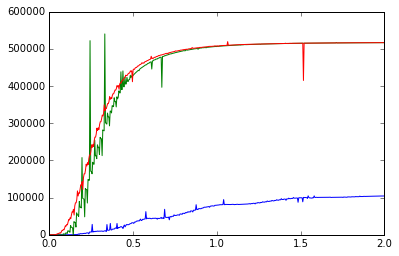

In [582]:
fig, ax = plt.subplots()

D1 = np.genfromtxt('data_txt/snr_comparison_rmin10_rmax200.txt')
_, _, kbin2, SNR_Xi = [D1[:,i] for i in range(D1[0,:].size)]
ax.plot(kbin2, SNR_Xi)

D1 = np.genfromtxt('data_txt/snr_comparison_rmin0_rmax200.txt')
_, _, kbin2, SNR_Xi = [D1[:,i] for i in range(D1[0,:].size)]
ax.plot(kbin2, SNR_Xi)

D1 = np.genfromtxt('data_txt/snr_comparison_rmin0_rmax500.txt')
_, _, kbin2, SNR_Xi = [D1[:,i] for i in range(D1[0,:].size)]
ax.plot(kbin2, SNR_Xi)

ax.set_ylim(0,6e+5)
